# **Solar PV Site Suitability Analysis in Kenya**

## **Business Understanding**

Access to clean, affordable, and sustainable energy is a cornerstone of economic development. Kenya has significant solar potential due to its high solar irradiance, but identifying the most suitable sites for solar photovoltaic (PV) projects requires more than just measuring sunlight.
Environmental, technical, and land use constraints (e.g., slope, water bodies, urban areas, protected areas) must be considered to avoid conflicts, minimize costs, and maximize power generation.

This project aims to provide a data-driven, GIS-based framework to locate optimal areas for solar PV installations.

## **Problem Statement**

Although solar irradiance data is available, decision-makers lack an integrated, spatially explicit model that combines solar resources (DNI, GHI, GTI, PVOUT, DIF), climate factors (temperature), and land constraints (protected areas, water bodies, forests, urban areas) to identify the most suitable zones for large-scale PV deployment.

Without this, investments may target suboptimal or environmentally sensitive sites, leading to:

- Increased project costs

- Land-use conflicts

- Reduced energy efficiency

## **Objectives**

The project will:

1. Integrate multi-source GIS data (irradiance, land use, constraints, climate).

2. Normalize and weight each factor based on its importance to solar PV suitability.

3. Develop a weighted overlay suitability model to produce a final suitability map.

4. Identify highly suitable regions for solar PV deployment in Kenya.

5. Provide insights to policymakers, investors, and planners to guide clean energy development.

## **Data Layers Used**

1. Solar resource: DIF, DNI, GHI, GTI, PVOUT

2. Climate: Temperature (TEMP)

3. Constraints: Protected areas, water bodies, urban areas, forests, agricultural areas

## **Metrics of Success**

✅ A suitability map that ranks all areas of Kenya (0–1 scale: unsuitable → highly suitable).

✅ At least 80% spatial agreement between identified suitable zones and known existing solar PV farms (validation).

✅ Usability of the model for decision-making: clear, interpretable maps for planners.

✅ Modular framework: ability to adjust weights and add/remove layers.

## **Methodology**

Step 1: Preprocess rasters (resample, normalize irradiance layers).

Step 2: Rasterize shapefiles (protected areas, forests, urban, water).

Step 3: Apply constraints (mask unsuitable areas = 0).

Step 4: Weighted overlay analysis (AHP / MCA).

Step 5: Generate suitability map.

Step 6: Validation (compare with known solar farms or theoretical hotspots).

# **Data Understanding**

The project integrates geospatial datasets from multiple sources to evaluate the suitability of locations for solar PV deployment in Kenya. These datasets represent both resource availability (how much solar energy is available) and constraints (where solar farms cannot or should not be built).

1. **Solar Radiation & Energy Potential Rasters**

- DNI (Direct Normal Irradiance) – measures solar radiation received per unit area by a surface always oriented toward the sun. Important for concentrating solar technologies but also a proxy for direct beam solar potential.

- DIF (Diffuse Horizontal Irradiance) – represents scattered sunlight received from the sky dome.

- GHI (Global Horizontal Irradiance) – the total solar radiation received on a horizontal surface; critical for PV system design.

- GTI (Global Tilted Irradiance) – the solar radiation on optimally tilted surfaces, more representative of actual PV installations.

- PVOUT (PV electricity output potential) – modeled electricity generation potential (kWh/kWp). This incorporates solar radiation and typical PV system efficiencies.

- TEMP (Ambient Temperature) – average surface air temperature, since higher temperatures reduce PV efficiency.

👉 Relevance: Together, these rasters describe both the solar energy resource (supply side) and the expected system performance (efficiency + yield).

2. **Environmental & Land-Use Constraints (Vector Data)**

- Protected Areas (shapefile) – National parks, reserves, or conservation areas where large-scale PV cannot be deployed.

- Water Bodies (shapefile) – Lakes, rivers, wetlands; unsuitable for PV development.

- Urban Areas (shapefile) – Cities and settlements; avoided for utility-scale PV but may be important for rooftop PV.

- Forests (shapefile) – Dense vegetation zones; often excluded due to environmental impacts.

👉 Relevance: These represent exclusion zones that reduce the technically usable land area.

3. **Auxiliary Data (Optional)**

- DEM (Digital Elevation Model) – used to derive slope. Steep terrain is less suitable for PV installation due to construction challenges.

- Slope & Elevation – if included, they add realism: flat/moderate slopes (<10°) are preferred.

👉 Note: DEM is not mandatory for a first version of the project, but improves accuracy.

4. **Spatial & Technical Considerations**

- Coordinate Reference System (CRS): All datasets must be projected to a common CRS (e.g., WGS84 EPSG:4326 or a UTM projection for Kenya).

- Resolution & Extent: Raster datasets vary in resolution (e.g., 1 km, 5 km). To compare them, resampling to a common grid is necessary.

- Data Quality Checks: Verifying missing values, nodata pixels, and valid attribute fields is essential before processing.

# **Data Preparation**

This phase involves cleaning, transforming, and organizing your spatial and tabular data so it can be meaningfully analyzed. Since you’re working with geographical raster and vector data, preparation is crucial.

## **Data cleaning**

- **Check coordinate reference systems (CRS):**

  - All your layers (DNI, DIF, GHI, GTI, PVOUT, TEMP, DEM, protected areas, water bodies, forests, urban areas) must be in the same projection (commonly WGS84 - EPSG:4326, or a suitable local projection).

  - If not, reproject them.

- **Remove unnecessary data:**

  - Clip the data to your study area (e.g., your country, region, or specific boundary).

  - This reduces computation and makes results clearer.

 ### 1. Import necessary libraries

In [2]:
# importing the necessary libraries
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from shapely.geometry import mapping
from rasterio.features import rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling   
from shapely.geometry import mapping
from rasterio.warp import reproject, Resampling
import os 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans   
from rasterio.merge import merge
from rasterio.plot import show
from sklearn.model_selection import train_test_split



### 2. Load the Kenya boundary

In [3]:
# Kenya boundary shapefile (this is your "study area")
kenya_boundary = gpd.read_file("kenya_Kenya_Country_Boundary.shp")
kenya_boundary = kenya_boundary.to_crs(epsg=4326)  # standard WGS84


### 3. Load raster layers

In [4]:
raster_files = {
    "DIF": "DIF.tif",
    "DNI": "DNI.tif",
    "GHI": "GHI.tif",
    "GTI": "GTI.tif",
    "PVOUT": "PVOUT.tif",
    "TEMP": "TEMP.tif"
}

rasters = {}
for key, path in raster_files.items():
    rasters[key] = rasterio.open(path)
    print(f"{key}: CRS={rasters[key].crs}, Bounds={rasters[key].bounds}")


DIF: CRS=EPSG:4326, Bounds=BoundingBox(left=33.0, bottom=-5.0, right=43.0, top=5.0)
DNI: CRS=EPSG:4326, Bounds=BoundingBox(left=33.0, bottom=-5.0, right=43.0, top=5.0)
GHI: CRS=EPSG:4326, Bounds=BoundingBox(left=33.0, bottom=-5.0, right=43.0, top=5.0)
GTI: CRS=EPSG:4326, Bounds=BoundingBox(left=33.0, bottom=-5.0, right=43.0, top=5.0)
PVOUT: CRS=EPSG:4326, Bounds=BoundingBox(left=33.0, bottom=-5.0, right=43.0, top=5.0)
TEMP: CRS=EPSG:4326, Bounds=BoundingBox(left=33.0, bottom=-5.0, right=43.0, top=5.0)
PVOUT: CRS=EPSG:4326, Bounds=BoundingBox(left=33.0, bottom=-5.0, right=43.0, top=5.0)
TEMP: CRS=EPSG:4326, Bounds=BoundingBox(left=33.0, bottom=-5.0, right=43.0, top=5.0)


### 4. Clip rasters to the Kenyan boundaries

In [5]:
def clip_raster(raster, boundary):
    geo = [mapping(boundary.unary_union)]  
    out_img, out_transform = mask(raster, geo, crop=True)
    out_meta = raster.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_img.shape[1],
        "width": out_img.shape[2],
        "transform": out_transform
    })
    return out_img, out_meta

clipped_rasters = {}
for key, raster in rasters.items():
    clipped_rasters[key] = clip_raster(raster, kenya_boundary)
    print(f"{key} clipped successfully.")


C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3870657882.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo = [mapping(boundary.unary_union)]


DIF clipped successfully.


C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3870657882.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo = [mapping(boundary.unary_union)]


DNI clipped successfully.


C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3870657882.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo = [mapping(boundary.unary_union)]


GHI clipped successfully.


C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3870657882.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo = [mapping(boundary.unary_union)]


GTI clipped successfully.


C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3870657882.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo = [mapping(boundary.unary_union)]


PVOUT clipped successfully.


C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3870657882.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo = [mapping(boundary.unary_union)]


TEMP clipped successfully.


### 5. Load vector layers

In [6]:
# Kenya boundary shapefile (already loaded earlier in your workflow)
kenya_boundary = gpd.read_file("kenya_Kenya_Country_Boundary.shp")

# Dictionary of vector layers
vector_files = {
    "Agriculture": "ke_agriculture.shp",
    "Protected": "ke_protected-areas.shp",
    "Water": "ke_waterbodies.shp",
    "Urban": "ke_urban.shp",
    "Forests": "ke_forests.shp",
    "Counties": "County.shp"
}

vectors = {}
for key, path in vector_files.items():
    gdf = gpd.read_file(path)

    # If CRS is missing, assign WGS84 (EPSG:4326)
    if gdf.crs is None:
        print(f"{key} has no CRS, assigning EPSG:4326 (WGS84).")
        gdf = gdf.set_crs(epsg=4326)

    # Reproject to Kenya CRS
    gdf = gdf.to_crs(kenya_boundary.crs)

    # Clip to Kenya boundary
    gdf = gpd.overlay(gdf, kenya_boundary, how="intersection")

    vectors[key] = gdf
    print(f"{key}: {len(gdf)} features after clipping.")

Agriculture: 2254 features after clipping.
Protected: 189 features after clipping.
Water has no CRS, assigning EPSG:4326 (WGS84).
Protected: 189 features after clipping.
Water has no CRS, assigning EPSG:4326 (WGS84).
Water: 201 features after clipping.
Water: 201 features after clipping.
Urban: 259 features after clipping.
Urban: 259 features after clipping.
Forests: 4715 features after clipping.
Forests: 4715 features after clipping.
Counties: 47 features after clipping.
Counties: 47 features after clipping.


### 6. Rasterize Vector Layers

In [7]:
def rasterize_layer(gdf, reference_meta):
    transform = reference_meta["transform"]
    out_shape = (reference_meta["height"], reference_meta["width"])
    shapes = ((geom, 1) for geom in gdf.geometry)
    raster = rasterize(shapes=shapes, out_shape=out_shape, transform=transform, fill=0, dtype="uint8")
    return raster

# Use DNI raster as reference
reference_meta = clipped_rasters["DNI"][1]

rasterized_layers = {}
for key, gdf in vectors.items():
    rasterized_layers[key] = rasterize_layer(gdf, reference_meta)
    print(f"{key} rasterized with values: {np.unique(rasterized_layers[key])}")


Agriculture rasterized with values: [0 1]
Protected rasterized with values: [0 1]
Protected rasterized with values: [0 1]
Water rasterized with values: [0 1]
Water rasterized with values: [0 1]
Urban rasterized with values: [0 1]
Urban rasterized with values: [0 1]
Forests rasterized with values: [0 1]
Forests rasterized with values: [0 1]
Counties rasterized with values: [0 1]
Counties rasterized with values: [0 1]


# **Exploratory Data Analysis**

## **Spatial Analysis**

### **Univariate Spatial Analysis**

In [8]:


# --- Load Kenya boundary ---
kenya_boundary = gpd.read_file("kenya_Kenya_Country_Boundary.shp")

def plot_raster(raster_path, title, cmap="viridis"):
    """Plot a raster (.tif) file clipped to Kenya boundary"""
    with rasterio.open(raster_path) as src:
        fig, ax = plt.subplots(figsize=(8, 8))
        show(src, ax=ax, cmap=cmap)
        kenya_boundary.boundary.plot(ax=ax, color="black", linewidth=1)
        ax.set_title(title)
        plt.show()

def plot_vector(vector_path, title, facecolor="lightgrey", edgecolor="black"):
    """Plot a shapefile clipped to Kenya boundary"""
    gdf = gpd.read_file(vector_path)

    # Ensure CRS is set
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=4326)

    # Reproject to Kenya CRS
    gdf = gdf.to_crs(kenya_boundary.crs)

    # Clip to Kenya boundary
    gdf = gpd.overlay(gdf, kenya_boundary, how="intersection")

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    kenya_boundary.boundary.plot(ax=ax, color="black", linewidth=1)
    gdf.plot(ax=ax, facecolor=facecolor, edgecolor=edgecolor)
    ax.set_title(title)
    plt.show()



DNI clipped and saved as DNI_Kenya.tif


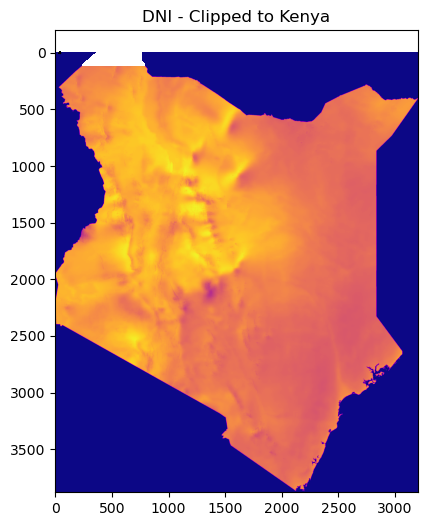

GHI clipped and saved as GHI_Kenya.tif


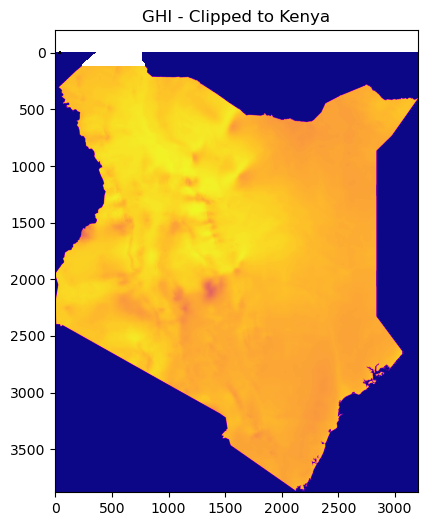

GTI clipped and saved as GTI_Kenya.tif


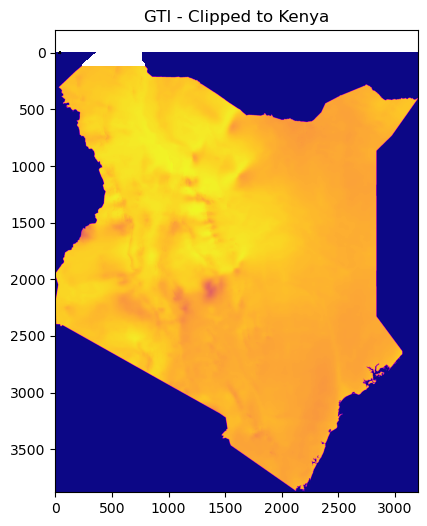

DIF clipped and saved as DIF_Kenya.tif


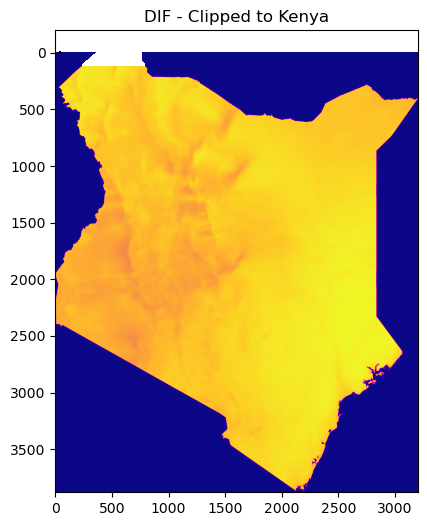

PVOUT clipped and saved as PVOUT_Kenya.tif


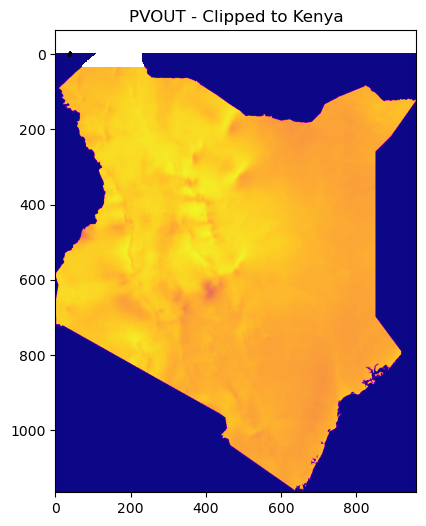

TEMP clipped and saved as TEMP_Kenya.tif


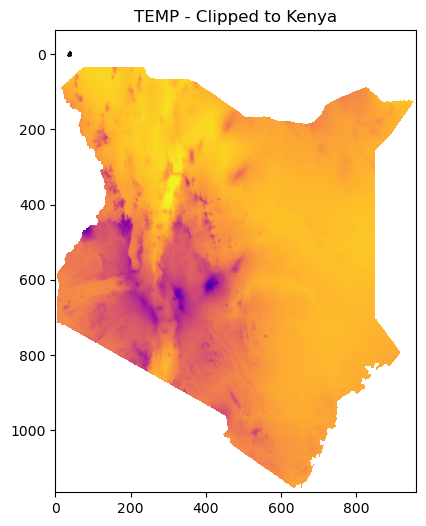

In [9]:

# --- Load Kenya boundary ---
kenya_boundary = gpd.read_file("kenya_Kenya_Country_Boundary.shp")
kenya_boundary = kenya_boundary.to_crs("EPSG:4326")   # base CRS

# --- List of rasters you want to clip ---
raster_files = {
    "DNI": "DNI.tif",
    "GHI": "GHI.tif",
    "GTI": "GTI.tif",
    "DIF": "DIF.tif",
    "PVOUT": "PVOUT.tif",
    "TEMP": "TEMP.tif"
}

clipped_rasters = {}

# --- Loop through rasters ---
for name, path in raster_files.items():
    with rasterio.open(path) as src:
        # match CRS
        kenya_boundary = kenya_boundary.to_crs(src.crs)
        
        # mask & crop
        out_image, out_transform = mask(src, kenya_boundary.geometry, crop=True)
        out_meta = src.meta.copy()
        
        # update metadata
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        # save clipped raster
        out_path = f"{name}_Kenya.tif"
        with rasterio.open(out_path, "w", **out_meta) as dest:
            dest.write(out_image)
        
        clipped_rasters[name] = out_image
        print(f"{name} clipped and saved as {out_path}")

        # quick plot
        plt.figure(figsize=(8,6))
        plt.imshow(out_image[0], cmap="plasma")
        kenya_boundary.boundary.plot(ax=plt.gca(), color="black", linewidth=1)
        plt.title(f"{name} - Clipped to Kenya")
        plt.show()


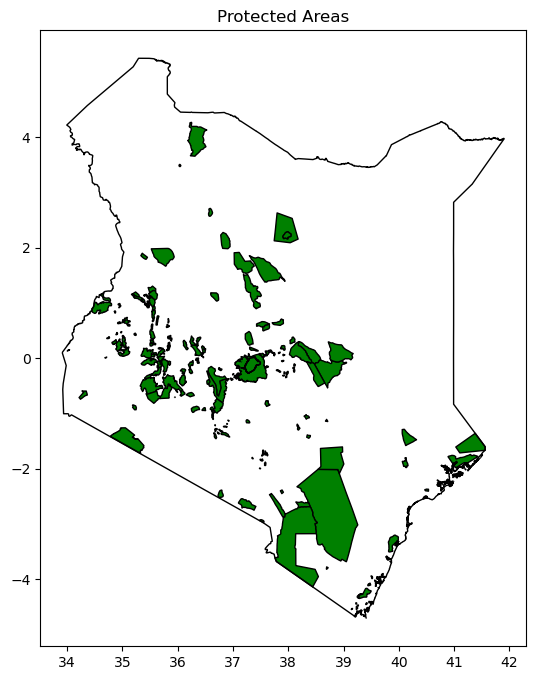

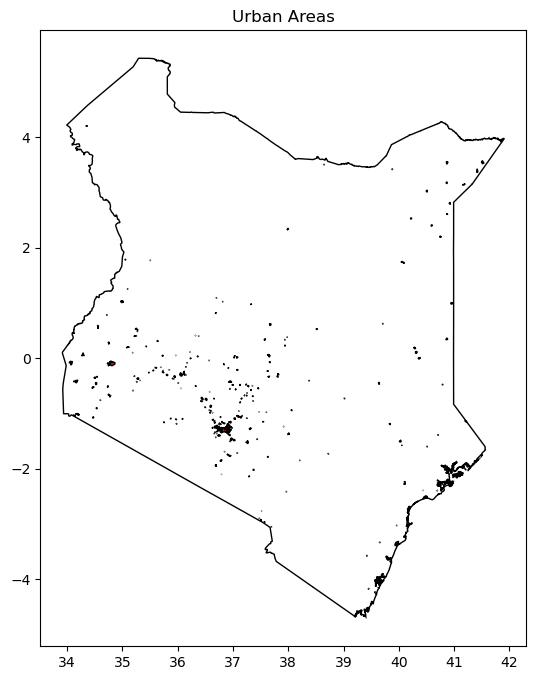

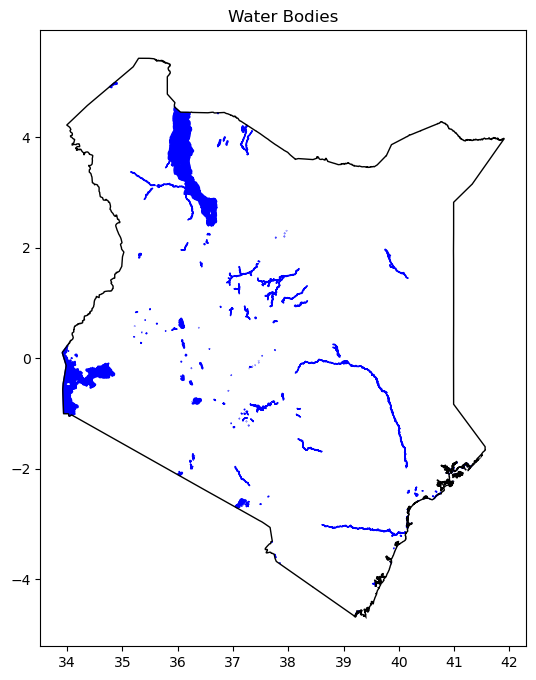

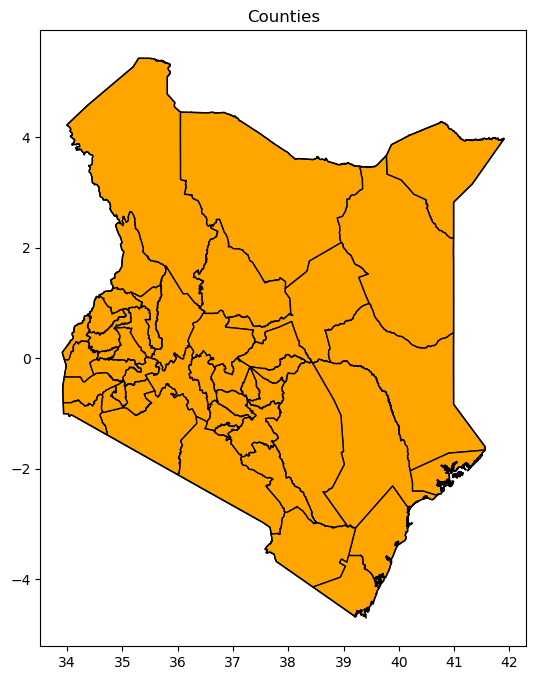

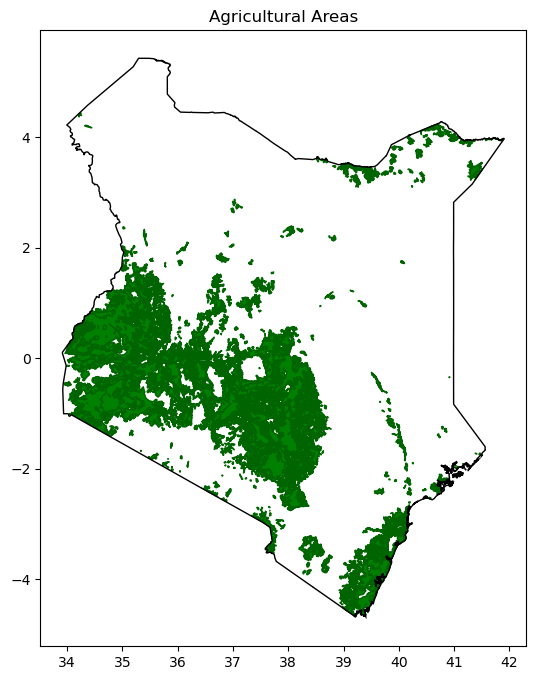

In [10]:


# For shapefile (Protected areas)
plot_vector("ke_protected-areas.shp", "Protected Areas", facecolor="green", edgecolor="black")

# For shapefile (Urban areas)
plot_vector("ke_urban.shp", "Urban Areas", facecolor="red", edgecolor="black")

#water bodies
plot_vector("ke_waterbodies.shp", "Water Bodies", facecolor="blue", edgecolor="blue")

#counties
plot_vector("County.shp", "Counties", facecolor="orange", edgecolor="black")

#Agriculture
plot_vector("ke_agriculture.shp", "Agricultural Areas", facecolor="green", edgecolor="darkgreen")


### Observation: DNI - Clipped to Kenya

- The Direct Normal Irradiance (DNI) map shows spatial variation in direct solar radiation across Kenya. 
- Higher DNI values are visible in the northeastern and some interior regions, indicating strong direct beam solar potential — beneficial for concentrating solar technologies and high-tilt PV systems. 
- Coastal and lake-adjacent areas show relatively lower DNI due to increased atmospheric moisture and cloudiness. 
- Use this map to prioritize locations where DNI is consistently high, but cross-reference with land-use constraints (protected areas, water bodies, urban zones) to ensure feasible site selection.

### Observation: GHI - Clipped to Kenya

- The Global Horizontal Irradiance (GHI) map represents total solar radiation on a horizontal surface; values are generally high across most of Kenya, highlighting broad PV potential.
- Regions in central and northern Kenya typically exhibit higher GHI — good candidates for utility-scale PV.
- Lower GHI along the western lake region and coastal strip suggests local cloudiness and atmospheric effects.
- Follow-up: compare GHI with PVOUT to account for temperature and other system losses.

### Observation: GTI - Clipped to Kenya

- Global Tilted Irradiance (GTI) estimates irradiance on an optimally tilted surface; it often shows slightly higher values than GHI in regions where tilt improves capture.
- GTI highlights areas where panel orientation would significantly increase yield — useful for site-level design.
- Use GTI together with slope/aspect from DEM to identify locations where natural terrain supports optimal tilt without excessive grading.

### Observation: DIF - Clipped to Kenya

- Diffuse Horizontal Irradiance (DIF) measures scattered light; higher DIF indicates cloudier or more overcast regions where diffuse radiation contributes more to total irradiance.
- Coastal and lake-adjacent zones often show elevated DIF relative to interior arid regions.
- While DNI favors direct-beam concentrating systems, higher DIF areas still support PV but may favor flat-plate modules optimized for diffuse light.

### Observation: PVOUT - Clipped to Kenya

- PVOUT maps modeled electricity output (kWh/kWp) and integrates irradiance and system performance factors; high PVOUT regions align with high GHI/GTI and moderate temperatures.
- Use PVOUT to prioritize sites for maximum energy yield per installed capacity.
- Cross-reference high PVOUT zones with land constraints (protected, urban, water) before site selection.

### Observation: TEMP - Clipped to Kenya

- Ambient temperature affects PV efficiency negatively — higher temperatures reduce module performance.
- Temperature maps show warmer lowland and interior regions; while these areas may have strong irradiance, slightly reduced module efficiency should be considered when estimating yield.
- Consider cooling strategies, module selection (temperature coefficient), or slightly increased capacity in hotter zones to compensate for efficiency losses.

### Observation: Protected Areas

- The protected areas map identifies conservation zones and legally protected lands where utility-scale solar development should be avoided.
- These zones must be excluded from suitability calculations or assigned zero suitability.
- For planning, buffer protected areas to avoid edge impacts and account for ecological corridors.

### Observation: Urban Areas

- Urban maps show settlements and built-up areas; these are generally unsuitable for large utility-scale PV (but suitable for distributed/rooftop PV).
- Exclude dense urban zones from candidate areas for ground-mounted farms, or treat them separately for rooftop potential assessments.

### Observation: Water Bodies

- Water bodies (lakes, rivers, wetlands) are unsuitable for PV installations and should be masked out of the suitability map.
- Note that nearshore wetlands and seasonal ponds may require additional local validation to avoid accidental inclusion.

### Observation: Counties

- The county boundaries map helps link spatial suitability outputs to administrative units for policy and planning.
- Use county-level aggregation of suitability (e.g., area above a suitability threshold) to prioritize regions for investment and permitting.

### Observation: Agricultural Areas

- Agricultural land layers identify croplands that might be in competition with solar farms; these areas may be lower priority or require stakeholder engagement.
- Consider dual-use (agrivoltaics) where appropriate, but validate site-level suitability and local land tenure.

### **Spatial Relationship Analysis**

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\2235504508.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved map to DNI_with_Protected_Areas.png


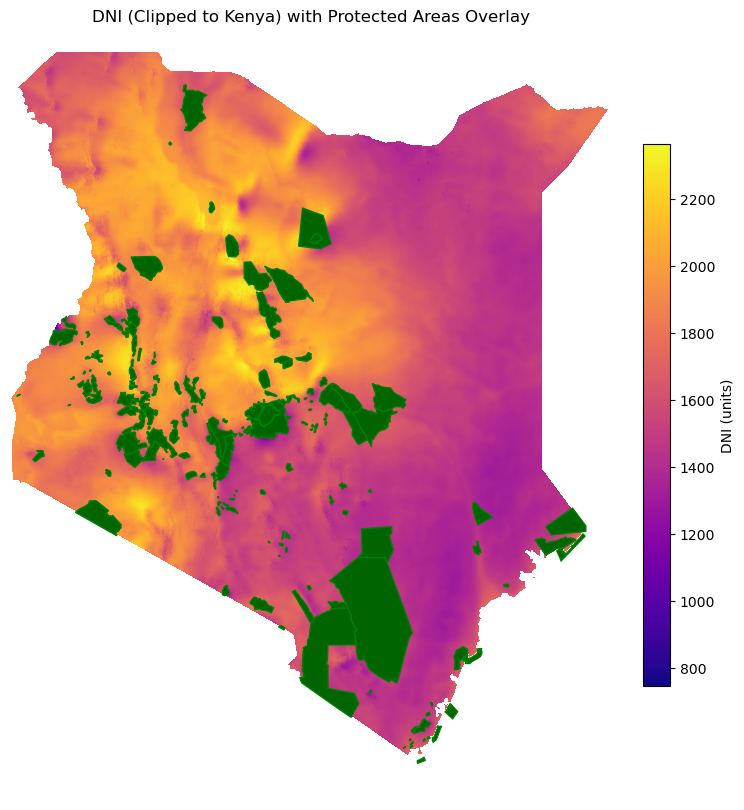

In [11]:
# Plot DNI raster with Protected Areas overlaid (with colorbar)


# Paths
dni_path = 'DNI_Kenya.tif'
protected_path = 'ke_protected-areas.shp'
out_png = 'DNI_with_Protected_Areas.png'

# Read protected areas
protected = gpd.read_file(protected_path)

# Open DNI raster and plot with overlay using imshow for colorbar control
with rasterio.open(dni_path) as src:
    arr = src.read(1)
    # mask nodata values for plotting
    arr = np.where(arr == src.nodata, np.nan, arr)
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    im = ax.imshow(arr, cmap='plasma', extent=extent, origin='upper')
    cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label('DNI (units)')

    # ensure protected areas are in same CRS as raster
    try:
        if protected.crs != src.crs:
            protected = protected.to_crs(src.crs)
    except Exception:
        protected = protected.set_crs(epsg=4326, allow_override=True).to_crs(src.crs)

    # plot protected areas as outlines so the raster remains visible
    protected.plot(ax=ax, facecolor='darkgreen', edgecolor='green', linewidth=1, label='Protected Areas')

    # cosmetics
    ax.set_title('DNI (Clipped to Kenya) with Protected Areas Overlay')
    ax.axis('off')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()

    # save figure
    fig.savefig(out_png, dpi=300, bbox_inches='tight')
    print(f'Saved map to {out_png}')
    plt.show()

### Observations: DNI with Protected Areas

- Protected areas overlap some regions with moderate-to-high DNI; these areas should be excluded from large-scale PV development to avoid ecological impacts.
- Note: Important conservation zones (e.g., national parks and reserves) may remove significant contiguous land from availability, fragmenting otherwise promising high-DNI regions.
- Recommendation: Use this overlay to mask protected zones from further suitability scoring and consider buffer zones to reduce edge impacts.

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\1738513452.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved map to DNI_with_Water_Bodies.png


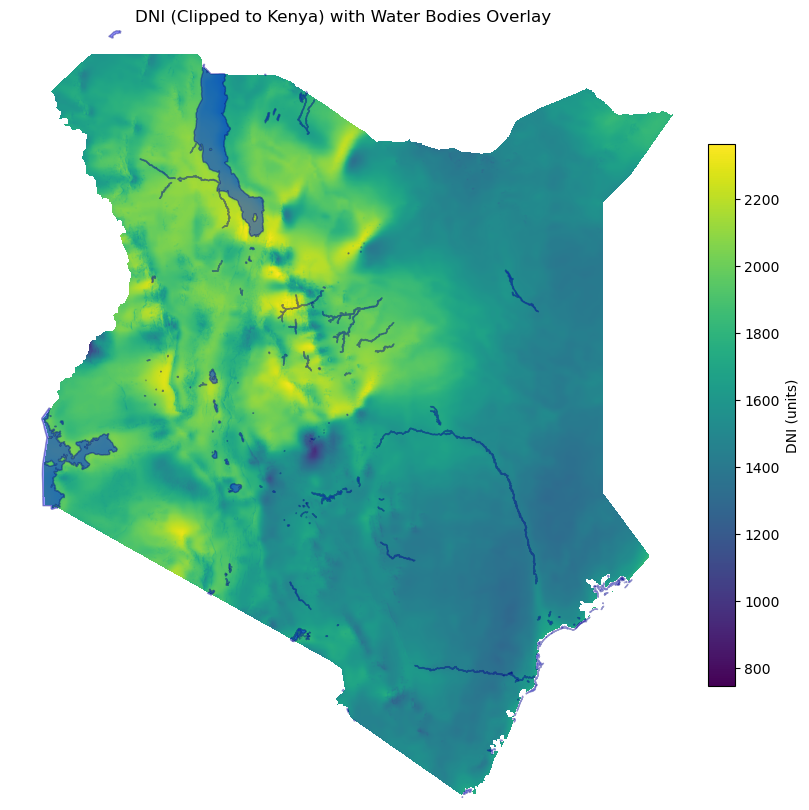

In [12]:
# Plot DNI raster with Water Bodies overlaid (with colorbar and save)

dni_path = 'DNI_Kenya.tif'
water_path = 'ke_waterbodies.shp'
out_png = 'DNI_with_Water_Bodies.png'

water = gpd.read_file(water_path)
with rasterio.open(dni_path) as src:
    arr = src.read(1)
    arr = np.where(arr == src.nodata, np.nan, arr)
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    im = ax.imshow(arr, cmap='viridis', extent=extent, origin='upper')
    cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label('DNI (units)')
    try:
        if water.crs != src.crs:
            water = water.to_crs(src.crs)
    except Exception:
        water = water.set_crs(epsg=4326, allow_override=True).to_crs(src.crs)
    water.plot(ax=ax, facecolor='blue', edgecolor='navy', alpha=0.4, label='Water Bodies')
    ax.set_title('DNI (Clipped to Kenya) with Water Bodies Overlay')
    ax.axis('off')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()
    fig.savefig(out_png, dpi=300, bbox_inches='tight')
    print(f'Saved map to {out_png}')
    plt.show()

### Observations: DNI with Water Bodies

- Water bodies (lakes, rivers, wetlands) appear in areas with lower DNI along shorelines; these are unsuitable for ground-mounted PV and should be masked out.
- Large lakes and river corridors can create local microclimates (increased humidity and cloudiness) that reduce direct irradiance near shorelines.
- Recommendation: Exclude water bodies from candidate areas and add a small buffer to account for wetland transitions and seasonal fluctuations.

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\2595391753.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved map to DNI_with_Forests.png


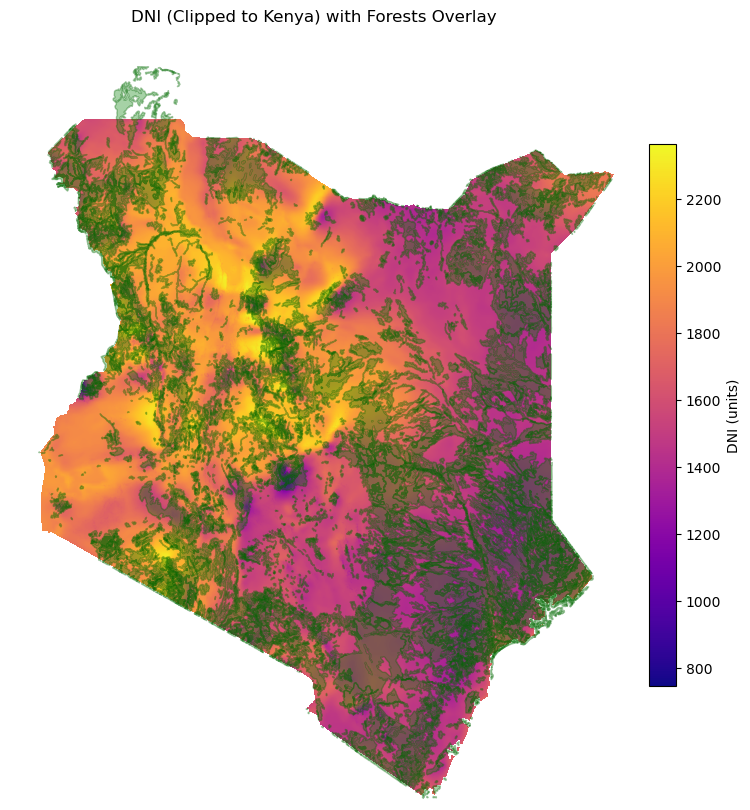

In [13]:
# Plot DNI raster with Forests overlaid (with colorbar and save)


dni_path = 'DNI_Kenya.tif'
forest_path = 'ke_forests.shp'
out_png = 'DNI_with_Forests.png'

forest = gpd.read_file(forest_path)
with rasterio.open(dni_path) as src:
    arr = src.read(1)
    arr = np.where(arr == src.nodata, np.nan, arr)
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    im = ax.imshow(arr, cmap='plasma', extent=extent, origin='upper')
    cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label('DNI (units)')
    try:
        if forest.crs != src.crs:
            forest = forest.to_crs(src.crs)
    except Exception:
        forest = forest.set_crs(epsg=4326, allow_override=True).to_crs(src.crs)
    forest.plot(ax=ax, facecolor='green', edgecolor='darkgreen', alpha=0.35, label='Forests')
    ax.set_title('DNI (Clipped to Kenya) with Forests Overlay')
    ax.axis('off')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()
    fig.savefig(out_png, dpi=300, bbox_inches='tight')
    print(f'Saved map to {out_png}')
    plt.show()

### Observations: DNI with Forests

- Forested areas usually coincide with lower surface irradiance at canopy level; these lands are often environmentally sensitive and should be excluded from large-scale PV.
- Forest cover can also indicate terrain or land-use constraints (steep slopes, conservation), reducing practical suitability even where DNI is moderate.
- Recommendation: Mask dense forest areas from suitability maps and assess smaller degraded or open-woodland patches separately if needed.

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\1788752578.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved map to DNI_with_Agricultural_Areas.png


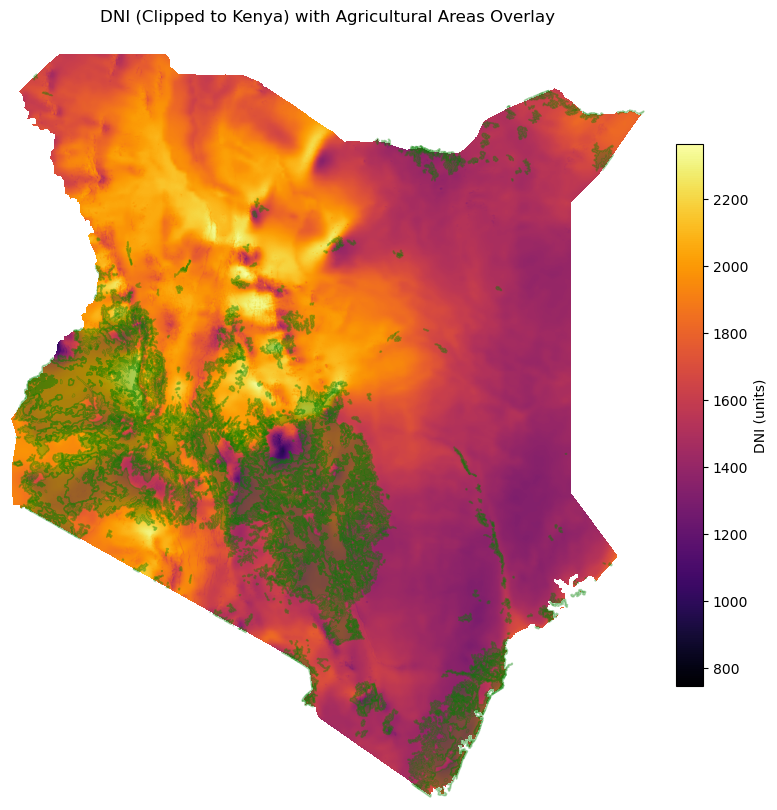

In [14]:
# Plot DNI raster with Agricultural Areas overlaid (with colorbar and save)


dni_path = 'DNI_Kenya.tif'
agri_path = 'ke_agriculture.shp'
out_png = 'DNI_with_Agricultural_Areas.png'

agri = gpd.read_file(agri_path)
with rasterio.open(dni_path) as src:
    arr = src.read(1)
    arr = np.where(arr == src.nodata, np.nan, arr)
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    im = ax.imshow(arr, cmap='inferno', extent=extent, origin='upper')
    cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label('DNI (units)')
    try:
        if agri.crs != src.crs:
            agri = agri.to_crs(src.crs)
    except Exception:
        agri = agri.set_crs(epsg=4326, allow_override=True).to_crs(src.crs)
    agri.plot(ax=ax, facecolor='green', edgecolor='green', alpha=0.3, label='Agricultural Areas')
    ax.set_title('DNI (Clipped to Kenya) with Agricultural Areas Overlay')
    ax.axis('off')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()
    fig.savefig(out_png, dpi=300, bbox_inches='tight')
    print(f'Saved map to {out_png}')
    plt.show()

### Observations: DNI with Agricultural Areas

- Agricultural areas often overlap with regions of moderate-to-high DNI; these lands may present competing uses for utility-scale PV.
- Opportunities exist for agrivoltaic systems where dual land use is acceptable, but this requires local stakeholder engagement and an assessment of crop compatibility.
- Recommendation: Flag agricultural zones for social/environmental review — consider alternate sites or agrivoltaics where appropriate.

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3491331527.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved DNI_with_Urban.png


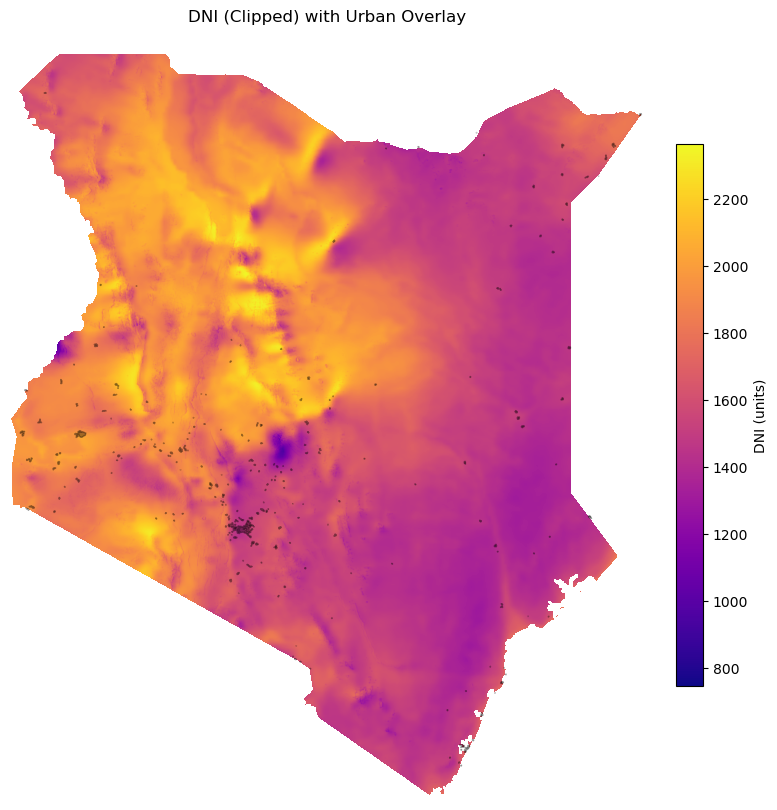

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3491331527.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved DNI_with_Counties.png


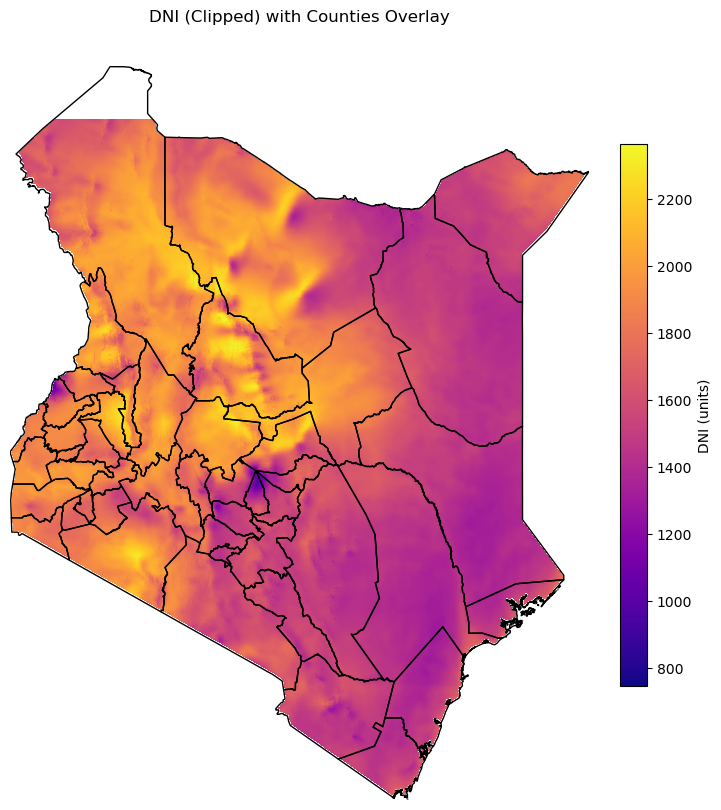

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3491331527.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved GHI_with_Urban.png


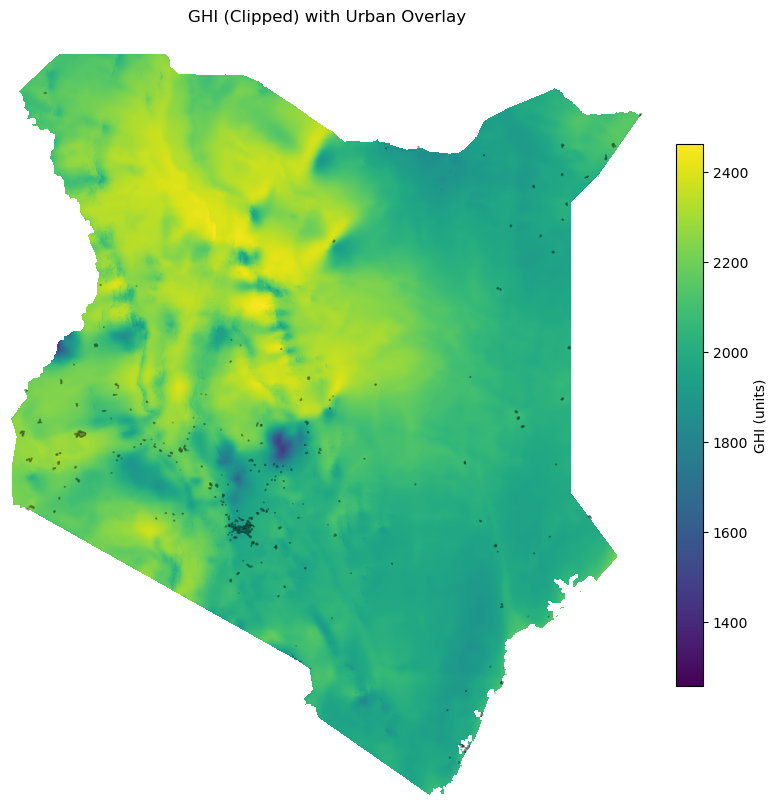

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3491331527.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved GHI_with_Counties.png


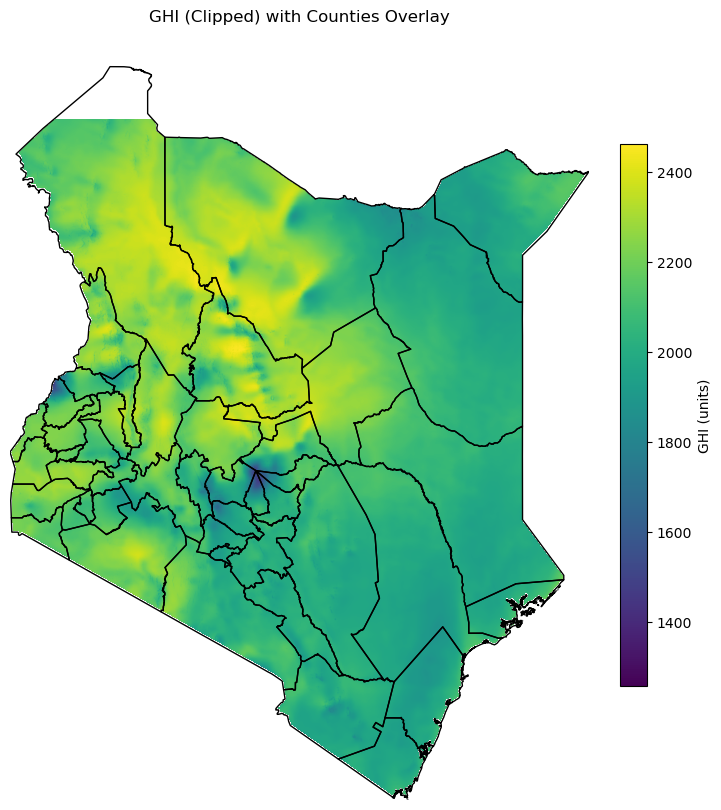

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3491331527.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved GTI_with_Urban.png


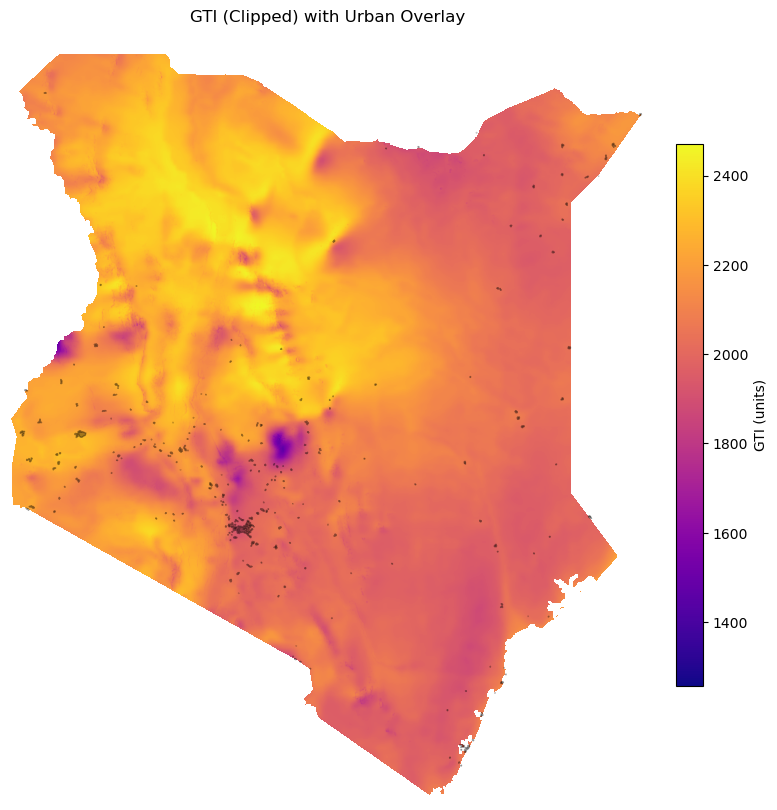

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3491331527.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved GTI_with_Counties.png


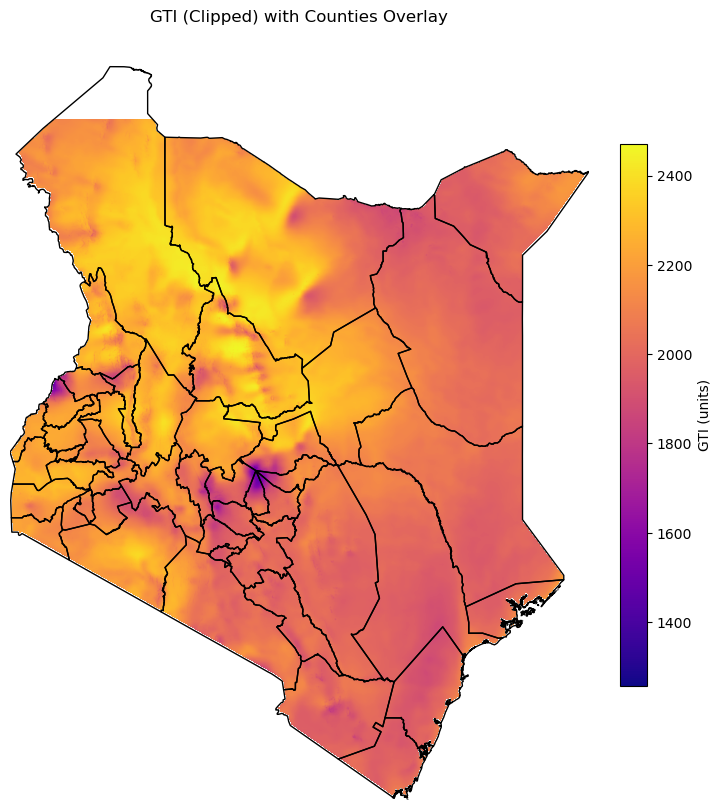

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3491331527.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved PVOUT_with_Urban.png


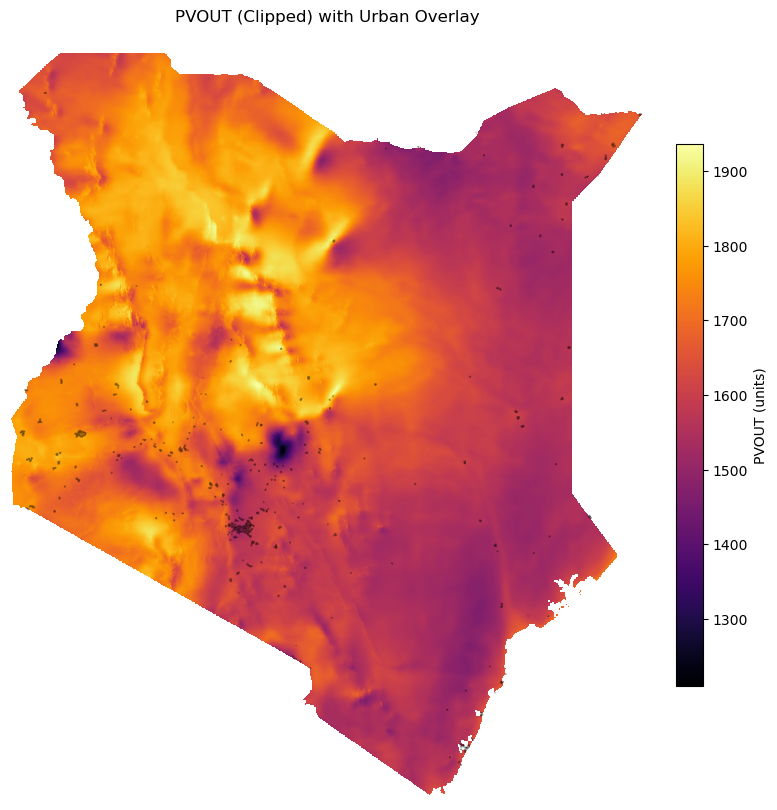

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3491331527.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Saved PVOUT_with_Counties.png


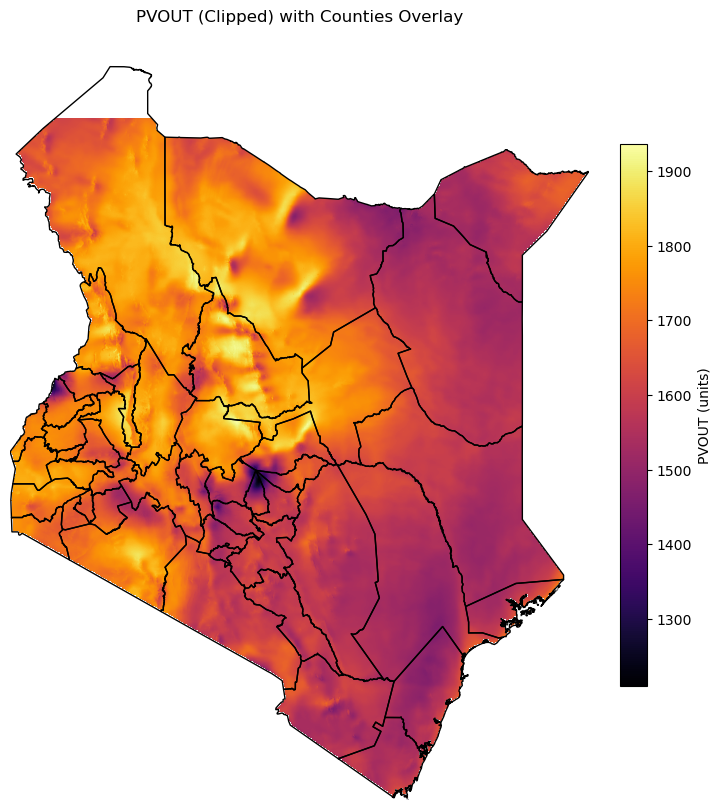

Batch plotting complete.


In [15]:
# Batch plot: DNI, GHI, GTI, PVOUT over Urban Areas and County boundaries


rasters = {
    'DNI': 'DNI_Kenya.tif',
    'GHI': 'GHI_Kenya.tif',
    'GTI': 'GTI_Kenya.tif',
    'PVOUT': 'PVOUT_Kenya.tif'
}
overlays = {
    'Urban': 'ke_urban.shp',
    'Counties': 'County.shp'
}
# Read overlay layers once
overlay_gdfs = {}
for name, path in overlays.items():
    try:
        overlay_gdfs[name] = gpd.read_file(path)
    except Exception as e:
        print(f'Could not read {path}: {e}')
        overlay_gdfs[name] = None

for rname, rpath in rasters.items():
    try:
        with rasterio.open(rpath) as src:
            arr = src.read(1)
            arr = np.where(arr == src.nodata, np.nan, arr)
            extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
            for oname, gdf in overlay_gdfs.items():
                if gdf is None:
                    print(f'Skipping overlay {oname} for {rname} (layer not loaded)')
                    continue
                fig, ax = plt.subplots(1,1,figsize=(10,10))
                im = ax.imshow(arr, cmap='viridis' if rname=='GHI' else ('plasma' if rname in ['DNI','GTI'] else 'inferno'), extent=extent, origin='upper')
                cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
                cbar.set_label(f'{rname} (units)')
                try:
                    if gdf.crs != src.crs:
                        gdf_plot = gdf.to_crs(src.crs)
                    else:
                        gdf_plot = gdf
                except Exception:
                    gdf_plot = gdf.set_crs(epsg=4326, allow_override=True).to_crs(src.crs)
                # style choices: urban = red transparent, counties = orange outline
                if oname == 'Urban':
                    gdf_plot.plot(ax=ax, facecolor='black', edgecolor='black', alpha=0.35, label=oname)
                else:
                    gdf_plot.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label=oname)
                ax.set_title(f'{rname} (Clipped) with {oname} Overlay')
                ax.axis('off')
                handles, labels = ax.get_legend_handles_labels()
                if handles:
                    ax.legend()
                out_png = f'{rname}_with_{oname}.png'
                fig.savefig(out_png, dpi=300, bbox_inches='tight')
                print(f'Saved {out_png}')
                plt.show()
    except Exception as e:
        print(f'Could not open raster {rpath}: {e}')

print('Batch plotting complete.')

### Observations: DNI with Urban Areas

- Urban areas often sit where DNI is moderate to low; dense settlements are generally unsuitable for ground-mounted large-scale PV but are important for rooftop PV planning.
- Where urban patches overlap higher DNI pockets, consider rooftop or distributed PV opportunities rather than land-based farms.
- Recommendation: exclude dense urban footprints from land suitability but map rooftop potential separately.

### Observations: DNI with County Boundaries

- County-level maps show how DNI resources are distributed administratively; some counties contain large contiguous high-DNI areas suitable for utility-scale projects.
- Use county aggregations (e.g., area above DNI threshold) to prioritize counties for detailed feasibility and permitting work.
- Recommendation: compute county summaries (mean, top-percentile DNI and available land area) to guide investment decisions.

### Observations: GHI with Urban Areas

- GHI is often high across many regions including peri-urban zones; however, urban cores remain poor candidates for ground-mounted PV due to land competition.
- Peri-urban and suburban open spaces with high GHI may be suitable for distributed utility sites if land-use and social constraints allow.
- Recommendation: pair GHI maps with land-use and tenure layers to screen urban-adjacent sites for small-to-medium PV plants.

### Observations: GHI with County Boundaries

- County-level GHI patterns highlight regions with consistently strong irradiance; counties in the central and northern belts typically rank higher.
- Use county GHI percentiles to shortlist jurisdictions for pre-feasibility before drilling to site-level checks (land availability, grid access).
- Recommendation: produce a ranked county list by GHI and combine with PVOUT for yield-focused prioritization.

### Observations: GTI with Urban Areas

- GTI (tilted irradiance) helps identify locations where panel orientation can boost yields; urban open spaces may benefit from optimized tilt but remain limited by land availability.
- Rooftop PV in urban zones can exploit GTI improvements with tilted installations; large ground-mounted arrays should focus outside dense urban footprints.
- Recommendation: prioritize GTI-informed rooftop and peri-urban ground projects where land is available and permissions are favorable.

### Observations: GTI with County Boundaries

- County GTI maps refine GHI-based insights by showing where tilt increases capture; counties with favorable GTI and available flat land are high-priority.
- Recommendation: combine GTI, slope, and land availability per county to identify candidate sites for high-efficiency layouts.

### Observations: PVOUT with Urban Areas

- PVOUT reflects modeled yield and already accounts for irradiance and some losses; urban areas typically show lower PVOUT for ground plants but rooftop PV remains viable.
- Use PVOUT over urban maps to identify high-yield rooftop neighborhoods or industrial roofs suitable for distributed generation.
- Recommendation: extract building footprints and rooftop-friendly PVOUT statistics for urban deployment planning.

### Observations: PVOUT with County Boundaries

- County-level PVOUT summaries directly indicate where installed capacity will produce most energy; combine PVOUT with land availability and constraints per county to rank development areas.
- Recommendation: calculate county-level metrics (total high-PVOUT area, mean PVOUT, percent of land constrained) to inform policy and investment prioritization.

## **Statistical/ Descriptive Analysis**

### **Univariate Analysis**

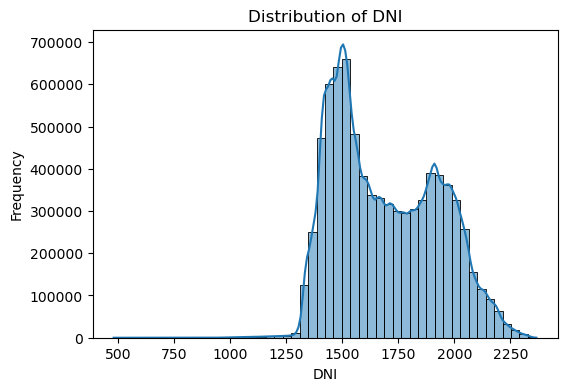

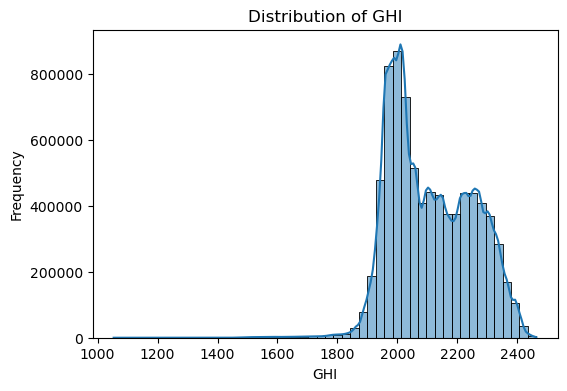

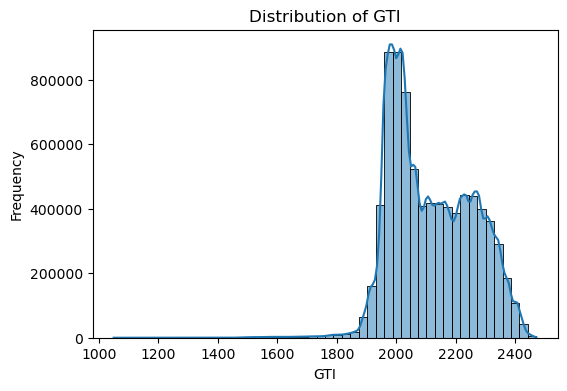

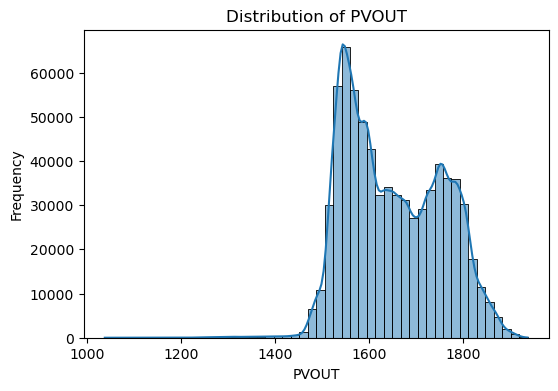

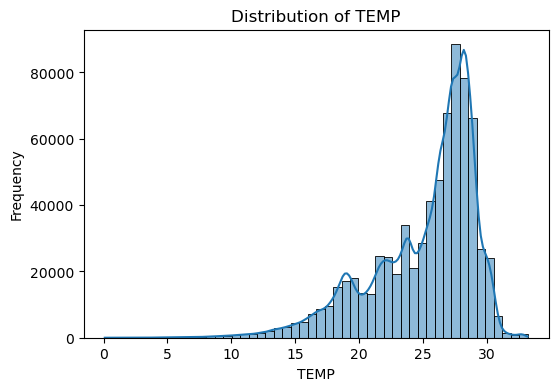

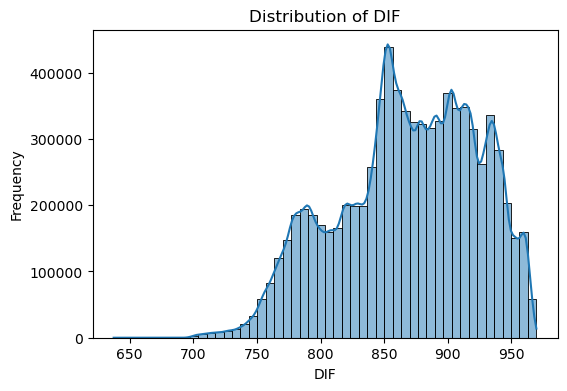

Raster Descriptive Statistics:
DNI: {'min': 478.8429870605469, 'max': 2366.090087890625, 'mean': 1692.9099983012306, 'std': 233.05706104467095}
GHI: {'min': 1053.7459716796875, 'max': 2463.24609375, 'mean': 2109.2515795110876, 'std': 137.64694929264238}
GTI: {'min': 1049.72802734375, 'max': 2471.281982421875, 'mean': 2116.268989869624, 'std': 138.17345179330266}
PVOUT: {'min': 1037.675048828125, 'max': 1936.9210205078125, 'mean': 1651.1593602419862, 'std': 102.87126933985517}
TEMP: {'min': 0.10000000149011612, 'max': 33.20000076293945, 'mean': 25.145793297857864, 'std': 4.107523235795554}
DIF: {'min': 637.3610229492188, 'max': 969.739013671875, 'mean': 868.3988173713891, 'std': 54.614165683764}


In [16]:

# Defensive raster descriptive statistics
raster_files = {
    "DNI": "DNI.tif",
    "GHI": "GHI.tif",
    "GTI": "GTI.tif",
    "PVOUT": "PVOUT.tif",
    "TEMP": "TEMP.tif",
    "DIF": "DIF.tif"
}

raster_stats = {}

for key, path in raster_files.items():
    try:
        with rasterio.open(path) as src:
            arr = src.read(1).astype(float)

            # Handle nodata robustly
            nodata = src.nodata
            if nodata is not None:
                arr[arr == nodata] = np.nan

            # If array is all nan, skip stats and plotting
            valid_mask = ~np.isnan(arr)
            if not np.any(valid_mask):
                print(f"Warning: {path} contains no valid data (all nodata/nan). Skipping stats & plot.")
                raster_stats[key] = {"min": None, "max": None, "mean": None, "std": None}
                continue

            stats = {
                "min": float(np.nanmin(arr)),
                "max": float(np.nanmax(arr)),
                "mean": float(np.nanmean(arr)),
                "std": float(np.nanstd(arr))
            }
            raster_stats[key] = stats

            # Plot histogram only when data exists
            plt.figure(figsize=(6, 4))
            sns.histplot(arr[valid_mask].ravel(), bins=50, kde=True)
            plt.title(f"Distribution of {key}")
            plt.xlabel(key)
            plt.ylabel("Frequency")
            plt.show()
    except FileNotFoundError:
        print(f"Raster file not found: {path}")
        raster_stats[key] = {"error": "file_not_found"}
    except Exception as e:
        print(f"Error reading raster {path}: {e}")
        raster_stats[key] = {"error": str(e)}

print("Raster Descriptive Statistics:")
for k, v in raster_stats.items():
    print(f"{k}: {v}")




### Observations: Raster Descriptive Statistics

- The histograms show the per-pixel distribution for each solar and climate indicator. Look for skewness (long tails) and outliers: a right-skew in irradiance layers indicates a small area with much higher resource than the national average.
- Summary stats (min, max, mean, std) provide quick guidance for thresholds. Consider using percentiles (e.g., 75th or 90th) rather than raw maxima to define high-resource candidates and avoid outlier-driven decisions.
- Large numbers of masked or NaN pixels indicate coverage or clipping issues—verify data completeness for those layers before relying on them.
- Recommendation: use these distributions to choose normalization method (percentile-based scaling is robust) and to set an operational cutoff for candidate sites (for example, areas above mean + 0.5*std or above the 75th percentile).

In [17]:
# -------------------
# Vector descriptive statistics (defensive)
# -------------------
vector_files = {
    "Water": "ke_waterbodies.shp",
    "Protected": "ke_protected-areas.shp",
    "Urban": "ke_urban.shp",
    "Forests": "ke_forests.shp"
}

vector_stats = {}

for key, path in vector_files.items():
    try:
        gdf = gpd.read_file(path)
    except FileNotFoundError:
        print(f"Vector file not found: {path}")
        vector_stats[key] = {"error": "file_not_found"}
        continue
    except Exception as e:
        print(f"Could not read {path}: {e}")
        vector_stats[key] = {"error": str(e)}
        continue

    # If empty GeoDataFrame
    if gdf.empty:
        print(f"Warning: {path} loaded but contains 0 features.")
        vector_stats[key] = {"count": 0, "total_area_km2": 0.0, "mean_area_km2": 0.0}
        continue

    # Ensure CRS is set
    try:
        if gdf.crs is None:
            print(f"{key} has no CRS, assigning EPSG:4326 (WGS84).")
            gdf = gdf.set_crs(epsg=4326, allow_override=True)

        # Project to metric CRS for area calculation
        gdf_m = gdf.to_crs(epsg=3857)
        gdf_m["area_km2"] = gdf_m.geometry.area / 1e6  # area in km²

        stats = {
            "count": int(len(gdf_m)),
            "total_area_km2": float(gdf_m["area_km2"].sum()),
            "mean_area_km2": float(gdf_m["area_km2"].mean()) if len(gdf_m) > 0 else 0.0
        }
        vector_stats[key] = stats
    except Exception as e:
        print(f"Error processing {key} ({path}): {e}")
        vector_stats[key] = {"error": str(e)}

print("\nVector Descriptive Statistics:")
for k, v in vector_stats.items():
    print(f"{k}: {v}")


Water has no CRS, assigning EPSG:4326 (WGS84).

Vector Descriptive Statistics:
Water: {'count': 208, 'total_area_km2': 13402.264782799191, 'mean_area_km2': 64.43396530191919}
Protected: {'count': 203, 'total_area_km2': 56784.104955318035, 'mean_area_km2': 279.72465495230557}
Urban: {'count': 260, 'total_area_km2': 730.2807984382135, 'mean_area_km2': 2.808772301685437}
Forests: {'count': 4764, 'total_area_km2': 232573.50688755373, 'mean_area_km2': 48.818956105699776}

Vector Descriptive Statistics:
Water: {'count': 208, 'total_area_km2': 13402.264782799191, 'mean_area_km2': 64.43396530191919}
Protected: {'count': 203, 'total_area_km2': 56784.104955318035, 'mean_area_km2': 279.72465495230557}
Urban: {'count': 260, 'total_area_km2': 730.2807984382135, 'mean_area_km2': 2.808772301685437}
Forests: {'count': 4764, 'total_area_km2': 232573.50688755373, 'mean_area_km2': 48.818956105699776}


### Observations: Vector Descriptive Statistics

- Vector summaries (count, total area, mean area) indicate how much land each constraint occupies; large total areas for forests or protected areas mean those constraints will heavily reduce candidate land.
- A high count with low mean area indicates fragmentation (many small polygons), which has implications for permitting and construction; aggregated large patches are often preferable for utility-scale PV.
- If any layer reports 0 features or an error, verify the shapefile path and clipping logic — empty outputs may indicate a projection or overlay problem.
- Recommendation: calculate percent of total land area constrained by each layer and use those percentages to inform weighting or exclusion decisions.

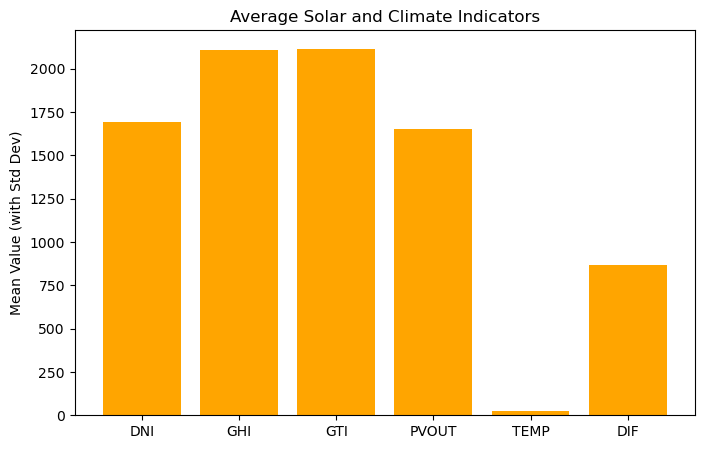

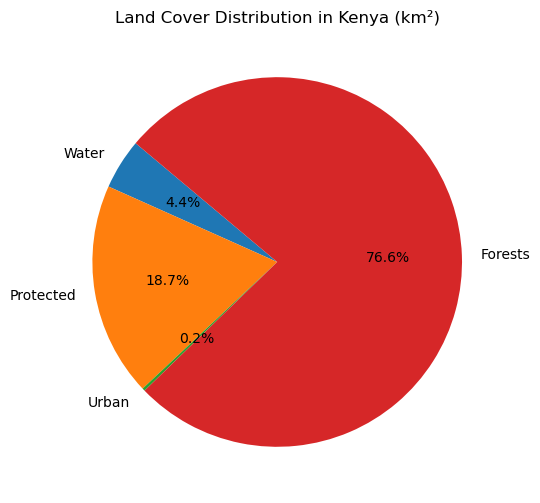

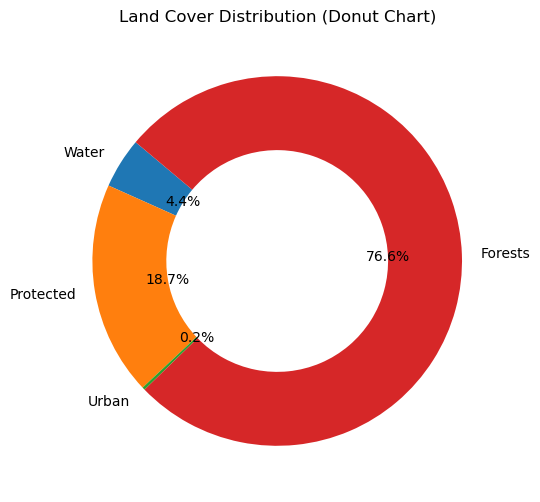

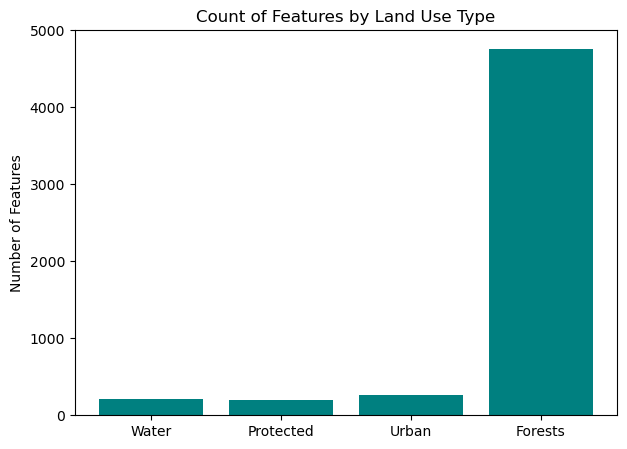

In [18]:


# -------------------
# Raster statistics visualization
# -------------------
raster_means = {k: v["mean"] for k, v in raster_stats.items()}
raster_std = {k: v["std"] for k, v in raster_stats.items()}

# Bar chart: average values of rasters
plt.figure(figsize=(8, 5))
plt.bar(raster_means.keys(), raster_means.values(), color="orange")
plt.ylabel("Mean Value (with Std Dev)")
plt.title("Average Solar and Climate Indicators")
plt.show()

# -------------------
# Vector statistics visualization
# -------------------
vector_areas = {k: v["total_area_km2"] for k, v in vector_stats.items()}

# Pie chart: share of land use
plt.figure(figsize=(6, 6))
plt.pie(vector_areas.values(), labels=vector_areas.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Land Cover Distribution in Kenya (km²)")
plt.show()

# Donut plot
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(vector_areas.values(), labels=vector_areas.keys(), autopct='%1.1f%%',
                                   startangle=140, wedgeprops=dict(width=0.4))
plt.title("Land Cover Distribution (Donut Chart)")
plt.show()

# Bar chart: feature counts
vector_counts = {k: v["count"] for k, v in vector_stats.items()}
plt.figure(figsize=(7, 5))
plt.bar(vector_counts.keys(), vector_counts.values(), color="teal")
plt.ylabel("Number of Features")
plt.title("Count of Features by Land Use Type")
plt.show()


### Observations: Raster & Vector Visualizations

- The bar chart of raster means helps identify which indicators dominate numerically and require normalization before combining layers; large differences suggest standardization is necessary.
- The pie/donut charts show the relative land area share of each constraint — large slices for protected areas or water bodies imply stricter exclusion will heavily narrow candidate areas.
- The feature counts bar indicates fragmentation: many small features complicate site assembly and permitting, while a few large contiguous polygons are usually more practical for site development.
- Recommendation: use these visual cues to define exclusion masks, choose normalization (e.g., z-score or percentile), and prioritize large contiguous areas for follow-up site-level assessment.

### **Bi-variate Analysis**

Resampled PVOUT to reference grid (DNI).
Resampled TEMP to reference grid (DNI).
Resampled TEMP to reference grid (DNI).


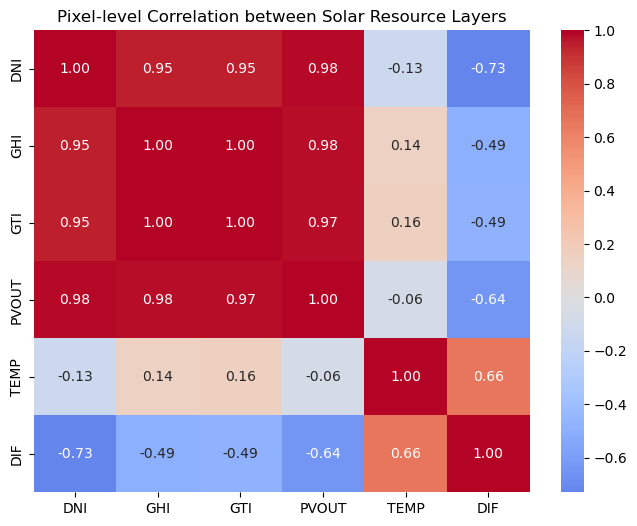

In [19]:


# Paths to your raster files
raster_files = {
    "DNI": "DNI.tif",
    "GHI": "GHI.tif",
    "GTI": "GTI.tif",
    "PVOUT": "PVOUT.tif",
    "TEMP": "TEMP.tif",
    "DIF": "DIF.tif"
}

# Read rasters into a dict with metadata
arrays = {}
for name, path in raster_files.items():
    try:
        with rasterio.open(path) as src:
            arr = src.read(1).astype(float)
            # prefer explicit nodata, otherwise mask very negative sentinel values
            nodata = src.nodata
            if nodata is not None:
                arr[arr == nodata] = np.nan
            else:
                # common sentinel used earlier in notebook
                arr[arr <= -9999] = np.nan

            arrays[name] = {
                "arr": arr,
                "transform": src.transform,
                "crs": src.crs,
                "shape": arr.shape
            }
    except FileNotFoundError:
        print(f"Raster file not found: {path} (skipping)")
    except Exception as e:
        print(f"Error reading {path}: {e}")

if len(arrays) < 2:
    print("Not enough rasters loaded to compute correlations. Aborting.")
else:
    # pick a reference grid (first loaded raster)
    ref_name = next(iter(arrays))
    ref = arrays[ref_name]
    ref_shape = ref["shape"]
    ref_transform = ref["transform"]
    ref_crs = ref["crs"]

    # Resample/reproject any raster that doesn't match the reference
    for name, meta in list(arrays.items()):
        if meta["shape"] != ref_shape or meta["crs"] != ref_crs:
            try:
                dest = np.full(ref_shape, np.nan, dtype=float)
                reproject(
                    source=meta["arr"],
                    destination=dest,
                    src_transform=meta["transform"],
                    src_crs=meta["crs"],
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.bilinear
                )
                arrays[name]["arr"] = dest
                arrays[name]["shape"] = dest.shape
                arrays[name]["transform"] = ref_transform
                arrays[name]["crs"] = ref_crs
                print(f"Resampled {name} to reference grid ({ref_name}).")
            except Exception as e:
                print(f"Could not resample {name} to reference grid: {e}")
                arrays.pop(name)

    # Ensure we still have at least two aligned rasters
    if len(arrays) < 2:
        print("Not enough compatible rasters after resampling/alignment. Aborting.")
    else:
        # Build DataFrame from flattened aligned rasters
        data = {}
        for name, meta in arrays.items():
            data[name] = meta["arr"].ravel()

        df = pd.DataFrame(data)

        # Drop rows with any NaNs to ensure pairwise pixel comparisons
        df_clean = df.dropna()
        if df_clean.shape[0] == 0:
            print("No overlapping valid pixels across rasters after masking. Cannot compute correlation.")
        else:
            corr = df_clean.corr()

            # Plot heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
            plt.title("Pixel-level Correlation between Solar Resource Layers")
            plt.show()


### Observations: Correlation Analysis

- The correlation heatmap shows pairwise relationships between resource layers. High correlation between GHI, GTI, and PVOUT is expected since PVOUT derives from irradiance; this indicates redundancy.
- Use correlations to decide which layers to keep or combine. If two layers correlate > 0.85, consider dropping or down-weighting one to avoid overemphasizing the same signal.
- Weak or negative correlations (e.g., DIF vs DNI) highlight areas with different solar regimes (diffuse vs direct), which may call for different PV technologies or designs.
- Recommendation: perform PCA or use PVOUT (which encapsulates irradiance and system effects) to reduce dimensionality before weighted overlay.

### **Multi-variate Analysis**

Raster Stats DataFrame:
            min      max     mean     std
DNI     478.84  2366.09  1692.91  233.06
GHI    1053.75  2463.25  2109.25  137.65
GTI    1049.73  2471.28  2116.27  138.17
PVOUT  1037.68  1936.92  1651.16  102.87
TEMP      0.10    33.20    25.15    4.11
DIF     637.36   969.74   868.40   54.61
Explained variance ratio: [0.84330234 0.15228518]


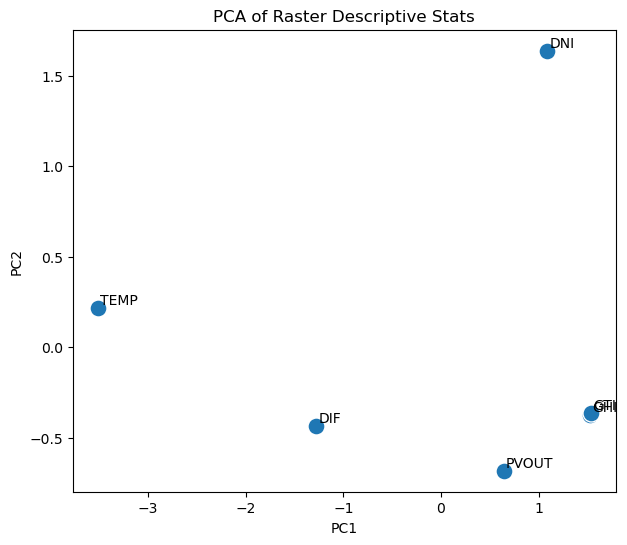

c:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Cluster Assignments:
        Cluster
DNI          0
GHI          0
GTI          0
PVOUT        0
TEMP         1
DIF          1


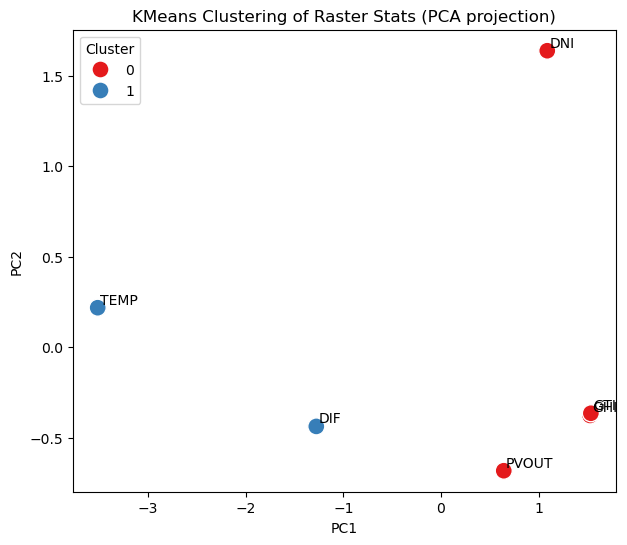

In [20]:


# -------------------------------
# 1. Construct dataframe from raster stats
# -------------------------------
raster_stats = {
    'DNI': {'min': 478.84, 'max': 2366.09, 'mean': 1692.91, 'std': 233.06},
    'GHI': {'min': 1053.75, 'max': 2463.25, 'mean': 2109.25, 'std': 137.65},
    'GTI': {'min': 1049.73, 'max': 2471.28, 'mean': 2116.27, 'std': 138.17},
    'PVOUT': {'min': 1037.68, 'max': 1936.92, 'mean': 1651.16, 'std': 102.87},
    'TEMP': {'min': 0.10, 'max': 33.20, 'mean': 25.15, 'std': 4.11},
    'DIF': {'min': 637.36, 'max': 969.74, 'mean': 868.40, 'std': 54.61}
}

df = pd.DataFrame(raster_stats).T
print("Raster Stats DataFrame:\n", df)

# -------------------------------
# 2. Scale the data
# -------------------------------
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# -------------------------------
# 3. PCA
# -------------------------------
pca = PCA(n_components=2)  # reduce to 2D for visualization
pca_result = pca.fit_transform(scaled_data)

df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=df.index)

# Variance explained
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot PCA scatter
plt.figure(figsize=(7,6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, s=150, marker='o')
for i in df_pca.index:
    plt.text(df_pca.loc[i, 'PC1']+0.02, df_pca.loc[i, 'PC2']+0.02, i, fontsize=10)
plt.title("PCA of Raster Descriptive Stats")
plt.show()

# -------------------------------
# 4. KMeans Clustering
# -------------------------------
kmeans = KMeans(n_clusters=2, random_state=42)  # try 2 clusters first
df['Cluster'] = kmeans.fit_predict(scaled_data)

print("\nCluster Assignments:\n", df[['Cluster']])

# Plot clustering on PCA space
plt.figure(figsize=(7,6))
sns.scatterplot(x='PC1', y='PC2', hue=df['Cluster'], palette='Set1', s=150, data=df_pca)
for i in df_pca.index:
    plt.text(df_pca.loc[i, 'PC1']+0.02, df_pca.loc[i, 'PC2']+0.02, i, fontsize=10)
plt.title("KMeans Clustering of Raster Stats (PCA projection)")
plt.show()


### Observations: KMeans Clustering

- The clustering groups raster indicators into clusters with similar statistical profiles. Interpret cluster labels by inspecting which indicators are in each cluster (see the printed cluster assignments).
- If PVOUT groups with GHI/GTI, it confirms PVOUT is strongly driven by irradiance; separate clustering of DIF or TEMP suggests they add complementary information.
- Recommendation: Use cluster membership to inform weighting — treat indicators from the same cluster as partially redundant and avoid giving them full independent weight in the final overlay. Consider collapsing cluster members into a single composite index if appropriate.

### Observations: PCA Results

- The PCA scatter projects raster descriptive statistics into two principal components that capture the largest shared variance. Check the explained variance ratio printed above: a high first-component ratio (>50%) means one latent factor (e.g., overall irradiance) explains most variability.
- Points close together indicate similar statistical profiles (e.g., GHI and GTI may cluster because they both measure broad irradiance). Points that are distant indicate unique behavior and are valuable to keep in the model.
- Recommendation: If PC1 explains most variance and primarily captures irradiance, consider using PC1 or PVOUT as a compact resource indicator in the weighted overlay to reduce redundancy.

# **Data Preprocessing**

### **1. Data Integration (Raster Stacking)**

- Combine all raster layers (DNI, GHI, GTI, DIF, TEMP, PVOUT) into a common grid.

- Ensure same resolution, CRS, and extent (clip to Kenya boundary).

- Stack them so every pixel has aligned values

### **2. Extract Features into a Tabular Dataset**

- Convert raster stack into a DataFrame:

  - Each pixel = 1 row

  - Each band (DNI, GHI, etc.) = 1 feature

- PVOUT = target (y)

### **3. Cleaning**

- Remove pixels with no-data values (e.g., -9999 or nan).

- Mask out irrelevant pixels outside Kenya (already done via clipping).

In [21]:
import rasterio
import rasterio.mask
import geopandas as gpd
import numpy as np
import pandas as pd
import os
from rasterio.merge import merge
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [22]:
# -----------------------------
# Import Libraries
# -----------------------------
""""" import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from shapely.geometry import mapping
import matplotlib.pyplot as plt

# -----------------------------
# Load Kenya Boundary
# -----------------------------
kenya_boundary = gpd.read_file("kenya_Kenya_Country_Boundary.shp")
kenya_boundary = kenya_boundary.to_crs(epsg=4326)

# -----------------------------
# Load Raster Files
# (Ensure these names match your files)
# -----------------------------
raster_paths = {
    "DNI": "DNI_Kenya.tif",
    "DIF": "DIF_Kenya.tif",
    "GHI": "GHI_Kenya.tif",
    "GTI": "GTI_Kenya.tif",
    "PVOUT": "PVOUT_Kenya.tif",
    "TEMP": "TEMP_Kenya.tif"
}

# -----------------------------
# Clip Rasters to Kenya Boundary
# -----------------------------
clipped_rasters = {}

for key, path in raster_paths.items():
    with rasterio.open(path) as src:
        geo = [mapping(kenya_boundary.union_all())]
        out_image, out_transform = rasterio.mask.mask(src, geo, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        clipped_rasters[key] = (out_image[0], out_meta)
        print(f"{key} clipped successfully.")

# -----------------------------
# Visualize a Sample Raster
# -----------------------------
plt.figure(figsize=(8, 6))
plt.imshow(clipped_rasters["DNI"][0], cmap="viridis")
plt.title("DNI - Clipped to Kenya Boundary")
plt.colorbar(label="DNI (W/m²)")
plt.show()

# -----------------------------
# Ensure All Rasters Have the Same Shape
# -----------------------------
base_shape = clipped_rasters["DNI"][0].shape
for key, (arr, _) in clipped_rasters.items():
    if arr.shape != base_shape:
        # Resample raster to match base raster
        print(f"Resampling {key} to match DNI dimensions...")
        from rasterio.enums import Resampling
        with rasterio.open(raster_paths[key]) as src:
            data = src.read(
                out_shape=(1, base_shape[0], base_shape[1]),
                resampling=Resampling.bilinear
            )[0]
        clipped_rasters[key] = (data, clipped_rasters["DNI"][1])

# -----------------------------
# Flatten Rasters into a DataFrame
# -----------------------------
rows, cols = base_shape
data = {}

for key, (arr, _) in clipped_rasters.items():
    data[key] = arr.flatten()

# Add geographic coordinates
transform = list(clipped_rasters.values())[0][1]["transform"]
x_coords, y_coords = np.meshgrid(np.arange(cols), np.arange(rows))
xs, ys = rasterio.transform.xy(transform, y_coords, x_coords)
data["X"] = np.array(xs).flatten()
data["Y"] = np.array(ys).flatten()

# Create DataFrame
df = pd.DataFrame(data)
df = df.dropna()  # drop any missing pixels
print(f"Final dataset shape: {df.shape}")
print(df.head())

# -----------------------------
# Load and Clip Vector Files
# -----------------------------
vector_files = {
    "Water": "ke_waterbodies.shp",
    "Protected": "ke_protected-areas.shp",
    "Urban": "ke_urban.shp",
    "Forests": "ke_forests.shp"
}

vectors = {}
for key, path in vector_files.items():
    gdf = gpd.read_file(path)
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=4326)
    gdf = gdf.to_crs(kenya_boundary.crs)
    gdf = gpd.overlay(gdf, kenya_boundary, how="intersection")
    vectors[key] = gdf
    print(f"{key}: {len(gdf)} features after clipping.")

# -----------------------------
# Optional: Plot Rasters and Vectors
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 6))
show_data = clipped_rasters["GHI"][0]
plt.imshow(show_data, cmap="inferno")
kenya_boundary.boundary.plot(ax=ax, color="black", linewidth=1)

for name, layer in vectors.items():
    layer.boundary.plot(ax=ax, label=name)

plt.legend()
plt.title("Solar Layers with Kenyan Boundaries and Vector Overlays")
plt.show()

# -----------------------------
# Save Cleaned Dataset for Modeling
# -----------------------------
df.to_csv("kenya_solar_dataset.csv", index=False)
print("✅ Cleaned dataset saved as kenya_solar_dataset.csv")"""""


'"" import geopandas as gpd\nimport rasterio\nimport rasterio.mask\nimport numpy as np\nimport pandas as pd\nfrom shapely.geometry import mapping\nimport matplotlib.pyplot as plt\n\n# -----------------------------\n# Load Kenya Boundary\n# -----------------------------\nkenya_boundary = gpd.read_file("kenya_Kenya_Country_Boundary.shp")\nkenya_boundary = kenya_boundary.to_crs(epsg=4326)\n\n# -----------------------------\n# Load Raster Files\n# (Ensure these names match your files)\n# -----------------------------\nraster_paths = {\n    "DNI": "DNI_Kenya.tif",\n    "DIF": "DIF_Kenya.tif",\n    "GHI": "GHI_Kenya.tif",\n    "GTI": "GTI_Kenya.tif",\n    "PVOUT": "PVOUT_Kenya.tif",\n    "TEMP": "TEMP_Kenya.tif"\n}\n\n# -----------------------------\n# Clip Rasters to Kenya Boundary\n# -----------------------------\nclipped_rasters = {}\n\nfor key, path in raster_paths.items():\n    with rasterio.open(path) as src:\n        geo = [mapping(kenya_boundary.union_all())]\n        out_image, out_

In [23]:
df = pd.read_csv("kenya_solar_dataset.csv")
print(f"Loaded dataset shape: {df.shape}")

Loaded dataset shape: (7557730, 8)


In [24]:
df.head()

DNI      DIF       GHI       GTI      PVOUT       TEMP         X  \
0  1592.125  929.196  2100.553  2116.989  1618.6653  29.807330  34.53125   
1  1591.759  929.561  2100.188  2116.624  1618.3365  29.837340  34.53375   
2  1591.029  929.561  2099.822  2116.258  1618.0078  29.867348  34.53625   
3  1590.299  929.926  2099.457  2115.893  1617.6791  29.897358  34.53875   
4  1589.568  929.926  2099.092  2115.528  1617.4031  29.900000  34.54125   

         Y  
0  4.70875  
1  4.70875  
2  4.70875  
3  4.70875  
4  4.70875

In [25]:


"""" # -----------------------------
# 1. Load the solar dataset (with X, Y)
# -----------------------------
df = pd.read_csv("kenya_solar_dataset.csv")

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["X"], df["Y"]),
    crs="EPSG:4326"
)

# -----------------------------
# 2. Load shapefiles and ensure same CRS
# -----------------------------
layers = {
    "Water": "ke_waterbodies.shp",
    "Urban": "ke_urban.shp",
    "Forests": "ke_forests.shp",
    "Protected": "ke_protected-areas.shp"
}

for key, path in layers.items():
    layer = gpd.read_file(path)
    print(f"{key} loaded successfully with {len(layer)} features.")

    # Fix missing CRS
    if layer.crs is None:
        print(f"⚠️ {key} has no CRS, assigning EPSG:4326 (WGS84).")
        layer.set_crs("EPSG:4326", inplace=True)

    # Align CRS
    if layer.crs != gdf_points.crs:
        print(f"Reprojecting {key} from {layer.crs} to {gdf_points.crs}")
        layer = layer.to_crs(gdf_points.crs)

    # -----------------------------
    # 3. Spatial containment test
    # -----------------------------
    gdf_points[f"{key.lower()}_area"] = gdf_points.geometry.within(layer.unary_union)
    gdf_points[f"{key.lower()}_area"] = gdf_points[f"{key.lower()}_area"].map({True: "Yes", False: "No"})

    print(f"✅ Added {key.lower()}_area column (Yes/No)")

# -----------------------------
# 4. Save the dataset
# -----------------------------
output_path = "solar_dataset_with_site_features.csv"
gdf_points.drop(columns="geometry").to_csv(output_path, index=False)

print(f"\n✅ Final dataset saved to: {output_path}")"""




'" # -----------------------------\n# 1. Load the solar dataset (with X, Y)\n# -----------------------------\ndf = pd.read_csv("kenya_solar_dataset.csv")\n\ngdf_points = gpd.GeoDataFrame(\n    df,\n    geometry=gpd.points_from_xy(df["X"], df["Y"]),\n    crs="EPSG:4326"\n)\n\n# -----------------------------\n# 2. Load shapefiles and ensure same CRS\n# -----------------------------\nlayers = {\n    "Water": "ke_waterbodies.shp",\n    "Urban": "ke_urban.shp",\n    "Forests": "ke_forests.shp",\n    "Protected": "ke_protected-areas.shp"\n}\n\nfor key, path in layers.items():\n    layer = gpd.read_file(path)\n    print(f"{key} loaded successfully with {len(layer)} features.")\n\n    # Fix missing CRS\n    if layer.crs is None:\n        print(f"⚠️ {key} has no CRS, assigning EPSG:4326 (WGS84).")\n        layer.set_crs("EPSG:4326", inplace=True)\n\n    # Align CRS\n    if layer.crs != gdf_points.crs:\n        print(f"Reprojecting {key} from {layer.crs} to {gdf_points.crs}")\n        layer = la

### **Exploring the new dataset**

In [26]:
df1 = pd.read_csv("solar_dataset_with_site_features.csv")
df1.head()

DNI      DIF       GHI       GTI      PVOUT       TEMP         X  \
0  1592.125  929.196  2100.553  2116.989  1618.6653  29.807330  34.53125   
1  1591.759  929.561  2100.188  2116.624  1618.3365  29.837340  34.53375   
2  1591.029  929.561  2099.822  2116.258  1618.0078  29.867348  34.53625   
3  1590.299  929.926  2099.457  2115.893  1617.6791  29.897358  34.53875   
4  1589.568  929.926  2099.092  2115.528  1617.4031  29.900000  34.54125   

         Y water_area urban_area forests_area protected_area  
0  4.70875         No         No           No             No  
1  4.70875         No         No           No             No  
2  4.70875         No         No           No             No  
3  4.70875         No         No           No             No  
4  4.70875         No         No           No             No

In [27]:
print(df1['water_area'].value_counts() )   
print(df1['urban_area'].value_counts() )   
print(df1['protected_area'].value_counts()) 
print(df1['forests_area'].value_counts())

water_area
No     7391056
Yes     166674
Name: count, dtype: int64
urban_area
No     7548474
Yes       9256
Name: count, dtype: int64
protected_area
No     6838832
Yes     718898
Name: count, dtype: int64
forests_area
No     4609440
Yes    2948290
Name: count, dtype: int64


In [28]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7557730 entries, 0 to 7557729
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   DNI             float64
 1   DIF             float64
 2   GHI             float64
 3   GTI             float64
 4   PVOUT           float64
 5   TEMP            float64
 6   X               float64
 7   Y               float64
 8   water_area      object 
 9   urban_area      object 
 10  forests_area    object 
 11  protected_area  object 
dtypes: float64(8), object(4)
memory usage: 691.9+ MB


In [29]:
df1.columns

Index(['DNI', 'DIF', 'GHI', 'GTI', 'PVOUT', 'TEMP', 'X', 'Y', 'water_area',
       'urban_area', 'forests_area', 'protected_area'],
      dtype='object')

In [30]:
df1.shape

(7557730, 12)

In [31]:
df1.describe().T

count         mean         std           min          25%  \
DNI    7557730.0  1693.019791  238.834291  1.175494e-38  1490.950000   
DIF    7557730.0   868.855734   58.964596  1.175494e-38   833.501000   
GHI    7557730.0  2109.640489  147.638838  1.175494e-38  1995.726000   
GTI    7557730.0  2116.453075  148.305011  1.175494e-38  2000.840000   
PVOUT  7557730.0  1651.948933  103.342991  1.209920e+03  1561.377900   
TEMP   7557730.0    25.161134    4.135830  1.412918e-01    22.852741   
X      7557730.0    37.848241    1.909150  3.392375e+01    36.256250   
Y      7557730.0     0.552966    2.196414 -4.663750e+00    -1.153750   

              50%          75%          max  
DNI    1649.83400  1899.300000  2366.090000  
DIF     874.04300   913.125000   969.739000  
GHI    2084.84700  2229.486000  2463.246000  
GTI    2089.96000  2236.060000  2471.282000  
PVOUT  1634.81630  1743.541400  1936.628800  
TEMP     26.60000    28.174267    33.184856  
X        37.93375    39.441250    41.893750  
Y         0.53125     2.421250     4.708750

In [32]:
df1.describe(include=['object']).T

count unique top     freq
water_area      7557730      2  No  7391056
urban_area      7557730      2  No  7548474
forests_area    7557730      2  No  4609440
protected_area  7557730      2  No  6838832

In [33]:
df1.duplicated().sum()  

0

In [34]:
df1.isnull().sum()  

DNI               0
DIF               0
GHI               0
GTI               0
PVOUT             0
TEMP              0
X                 0
Y                 0
water_area        0
urban_area        0
forests_area      0
protected_area    0
dtype: int64

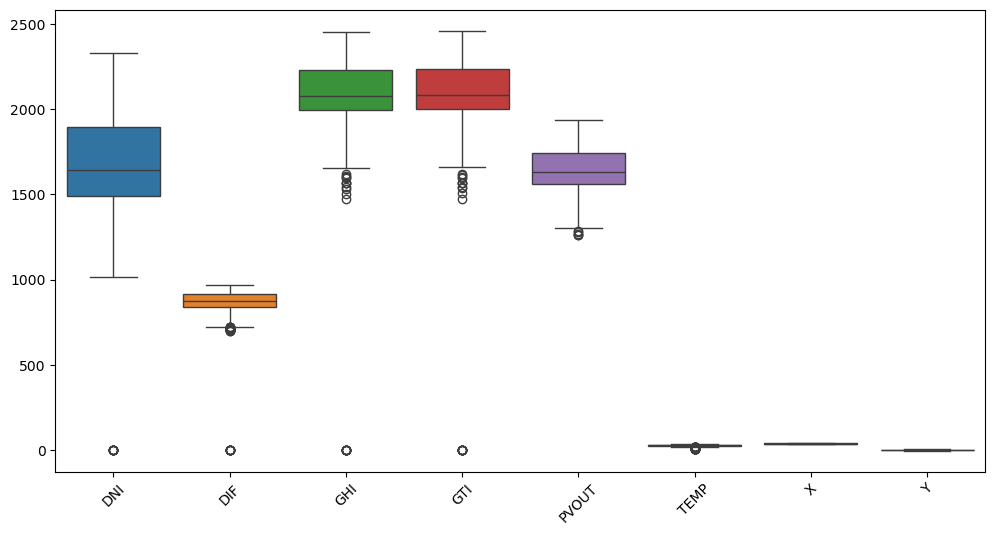

In [35]:
# Outliers
# Take a smaller random sample (e.g., 10,000 rows)
df_sample = df1.sample(n=10000, random_state=42)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sample)
plt.xticks(rotation=45)
plt.show()


## **Feature Engineering**

### 1. Derived Solar Radiation Features

These help the model understand solar potential patterns more deeply.

In [36]:
df1["DNI_to_GHI_ratio"] = df1["DNI"] / df1["GHI"]        # Direct-to-total irradiance ratio
df1["GTI_to_GHI_ratio"] = df1["GTI"] / df1["GHI"]        # Tilted vs horizontal radiation
df1["Diffuse_fraction"] = df1["DIF"] / df1["GHI"]        # Fraction of scattered light


➡️ These ratios show how much direct vs diffuse solar energy a site receives — key for PV efficiency.

### 2. Temperature-Related Features

Temperature affects PV performance. You can model non-linear effects.

In [37]:
df1["TEMP_log"] = np.log1p(df1["TEMP"])   # Log transform for skewed distribution

➡️ This helps models capture how extremely high temperatures reduce panel efficiency.

### 3. Spatial Features

Latitude (Y) and longitude (X) can be used more effectively through trigonometric encoding.

In [38]:
df1["X_sin"] = np.sin(np.radians(df1["X"]))
df1["X_cos"] = np.cos(np.radians(df1["X"]))
df1["Y_sin"] = np.sin(np.radians(df1["Y"]))
df1["Y_cos"] = np.cos(np.radians(df1["Y"]))


➡️ This helps tree and linear models detect geographic patterns more naturally.

### 5. Composite Solar Potential Index 

You can engineer an aggregate index that combines solar irradiance and temperature.

In [39]:
df1["Solar_Potential_Index"] = (df1["GHI"] + df1["GTI"]) / (df1["TEMP"] + 1)


### 6. Define Suitability Classes (based on PVOUT)

In [40]:


# -------------------------------
# 1️⃣ Land-use columns cleanup
# -------------------------------
land_use_cols = ["water_area", "urban_area", "forests_area", "protected_area"]

# Convert "Yes"/"No" → binary 1/0 for easier calculations
for col in land_use_cols:
    df1[col] = df1[col].astype(str).str.lower().map({"yes": 1, "no": 0})

# -------------------------------
# 2️⃣ Define base suitability based on PVOUT thresholds
# -------------------------------
conditions = [
    (df1["PVOUT"] < 1400),
    (df1["PVOUT"] >= 1400) & (df1["PVOUT"] < 1600),
    (df1["PVOUT"] >= 1600)
]
choices = ["Low", "Moderate", "High"]

df1["Base_Suitability"] = np.select(conditions, choices)

# -------------------------------
# 3️⃣ Penalize restricted zones
# -------------------------------
df1["Restricted"] = df1[land_use_cols].sum(axis=1) > 0

# Final categorical suitability label
df1["Site_Suitability"] = np.where(df1["Restricted"], "Unsuitable", df1["Base_Suitability"])

# -------------------------------
# 4️⃣ Optional: create numeric suitability index
# -------------------------------
df1["Suitability_Index"] = (
    0.4 * (df1["DNI"] / df1["DNI"].max()) +
    0.3 * (df1["GHI"] / df1["GHI"].max()) +
    0.2 * (df1["GTI"] / df1["GTI"].max()) -
    0.1 * (df1["TEMP"] / df1["TEMP"].max())
)

# Reduce index to 0 for unsuitable zones
df1.loc[df1["Restricted"], "Suitability_Index"] = 0

# -------------------------------
# 5️⃣ Clean up (optional)
# -------------------------------
df1.drop(columns=["Restricted", "Base_Suitability"], inplace=True)

# -------------------------------
# 6️⃣ Check results
# -------------------------------
print(df1["Site_Suitability"].value_counts())
print(df1[["Site_Suitability", "Suitability_Index"]].head())


Site_Suitability
Unsuitable    3392496
High          2782282
Moderate      1382563
Low               389
Name: count, dtype: int64
  Site_Suitability  Suitability_Index
0             High           0.606490
1             High           0.606263
2             High           0.605975
3             High           0.605687
4             High           0.605482


In [41]:
df1.head()

DNI      DIF       GHI       GTI      PVOUT       TEMP         X  \
0  1592.125  929.196  2100.553  2116.989  1618.6653  29.807330  34.53125   
1  1591.759  929.561  2100.188  2116.624  1618.3365  29.837340  34.53375   
2  1591.029  929.561  2099.822  2116.258  1618.0078  29.867348  34.53625   
3  1590.299  929.926  2099.457  2115.893  1617.6791  29.897358  34.53875   
4  1589.568  929.926  2099.092  2115.528  1617.4031  29.900000  34.54125   

         Y  water_area  urban_area  ...  GTI_to_GHI_ratio  Diffuse_fraction  \
0  4.70875           0           0  ...          1.007825          0.442358   
1  4.70875           0           0  ...          1.007826          0.442608   
2  4.70875           0           0  ...          1.007827          0.442686   
3  4.70875           0           0  ...          1.007829          0.442936   
4  4.70875           0           0  ...          1.007830          0.443013   

   TEMP_log     X_sin     X_cos     Y_sin     Y_cos  Solar_Potential_Index  \
0  3.427753  0.566856  0.823817  0.082091  0.996625             136.900601   
1  3.428726  0.566892  0.823792  0.082091  0.996625             136.743701   
2  3.429699  0.566928  0.823768  0.082091  0.996625             136.587050   
3  3.430671  0.566963  0.823743  0.082091  0.996625             136.430759   
4  3.430756  0.566999  0.823718  0.082091  0.996625             136.395469   

   Site_Suitability  Suitability_Index  
0              High           0.606490  
1              High           0.606263  
2              High           0.605975  
3              High           0.605687  
4              High           0.605482  

[5 rows x 23 columns]

In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7557730 entries, 0 to 7557729
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   DNI                    float64
 1   DIF                    float64
 2   GHI                    float64
 3   GTI                    float64
 4   PVOUT                  float64
 5   TEMP                   float64
 6   X                      float64
 7   Y                      float64
 8   water_area             int64  
 9   urban_area             int64  
 10  forests_area           int64  
 11  protected_area         int64  
 12  DNI_to_GHI_ratio       float64
 13  GTI_to_GHI_ratio       float64
 14  Diffuse_fraction       float64
 15  TEMP_log               float64
 16  X_sin                  float64
 17  X_cos                  float64
 18  Y_sin                  float64
 19  Y_cos                  float64
 20  Solar_Potential_Index  float64
 21  Site_Suitability       object 
 22  Suitability_Index 

# **Exploratory Data Analysis 2 for the dataset**

In [43]:
# Sampling the dataset
# Sample 100,000 rows from the full dataset
sample_df = df1.sample(n=100000, random_state=42)


In [44]:
sample_df

DNI      DIF       GHI       GTI      PVOUT       TEMP  \
5321481  1740.781  788.210  2076.081  2077.542  1649.8435  18.817997   
5741941  1402.560  955.129  1982.577  1983.673  1538.7780  27.600000   
3886531  1915.736  777.617  2201.727  2206.475  1725.4980  21.609678   
220126   1696.221  921.526  2155.340  2170.681  1665.0110  29.100000   
7523147  1536.607  891.575  1997.918  2003.762  1571.5658  25.416640   
...           ...      ...       ...       ...        ...        ...   
6383959  1389.776  954.033  1965.776  1967.967  1529.8431  27.500000   
2647570  1860.949  877.330  2236.060  2240.443  1728.2161  28.600000   
349083   1729.094  909.472  2182.004  2196.979  1672.1064  31.100000   
2322215  1713.388  901.072  2152.053  2157.166  1666.2208  28.400000   
4720287  1994.265  764.103  2282.082  2282.812  1779.3100  24.105362   

                X        Y  water_area  urban_area  ...  GTI_to_GHI_ratio  \
5321481  35.46125 -0.84625           0           0  ...          1.000704   
5741941  40.95125 -1.21875           0           0  ...          1.000553   
3886531  34.82875  0.43125           0           0  ...          1.002156   
220126   34.57625  4.14125           0           0  ...          1.007118   
7523147  39.20875 -4.25375           0           0  ...          1.002925   
...           ...      ...         ...         ...  ...               ...   
6383959  40.46125 -1.84125           0           0  ...          1.001115   
2647570  38.50125  1.63375           0           0  ...          1.001960   
349083   36.42125  3.95375           0           0  ...          1.006863   
2322215  38.57375  1.97375           0           0  ...          1.002376   
4720287  34.84625 -0.31375           0           0  ...          1.000320   

         Diffuse_fraction  TEMP_log     X_sin     X_cos     Y_sin     Y_cos  \
5321481          0.379662  2.986590  0.580152  0.814508 -0.014769  0.999891   
5741941          0.481761  3.353407  0.655417  0.755268 -0.021270  0.999774   
3886531          0.353185  3.118378  0.571126  0.820863  0.007527  0.999972   
220126           0.427555  3.404525  0.567502  0.823372  0.072216  0.997389   
7523147          0.446252  3.273994  0.632148  0.774848 -0.074174  0.997245   
...                   ...       ...       ...       ...       ...       ...   
6383959          0.485321  3.349904  0.648934  0.760845 -0.032130  0.999484   
2647570          0.392355  3.387774  0.622532  0.782595  0.028510  0.999593   
349083           0.416806  3.468856  0.593717  0.804674  0.068951  0.997620   
2322215          0.418703  3.380995  0.623521  0.781806  0.034442  0.999407   
4720287          0.334827  3.223081  0.571376  0.820688 -0.005476  0.999985   

         Solar_Potential_Index  Site_Suitability  Suitability_Index  
5321481             209.588436              High           0.658563  
5741941             138.680070        Unsuitable           0.000000  
3886531             194.969694              High           0.705465  
220126              143.721628              High           0.637237  
7523147             151.483307          Moderate           0.588672  
...                        ...               ...                ...  
6383959             138.026070          Moderate           0.550760  
2647570             151.233209              High           0.682069  
349083              136.416916        Unsuitable           0.000000  
2322215             146.572075              High           0.640754  
4720287             181.829443              High           0.727185  

[100000 rows x 23 columns]

## **Univariate Analysis**

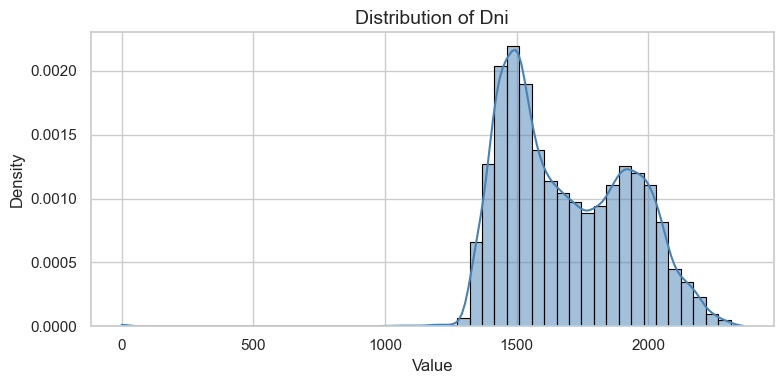

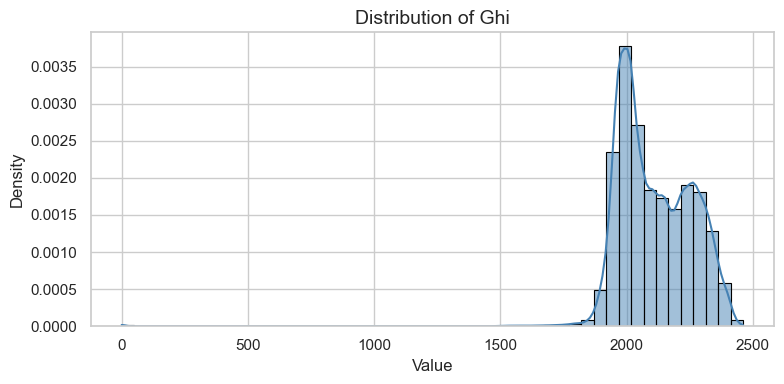

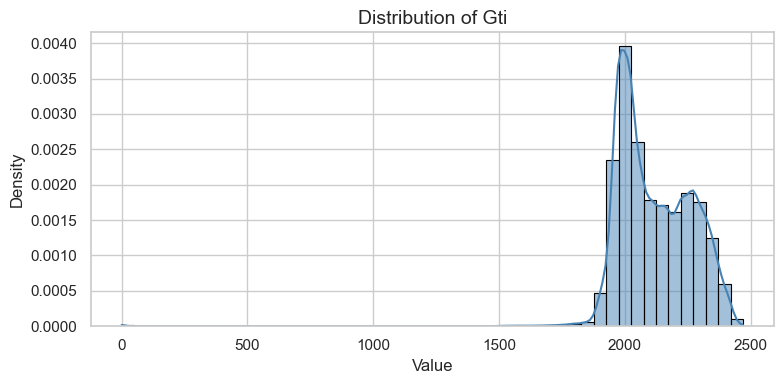

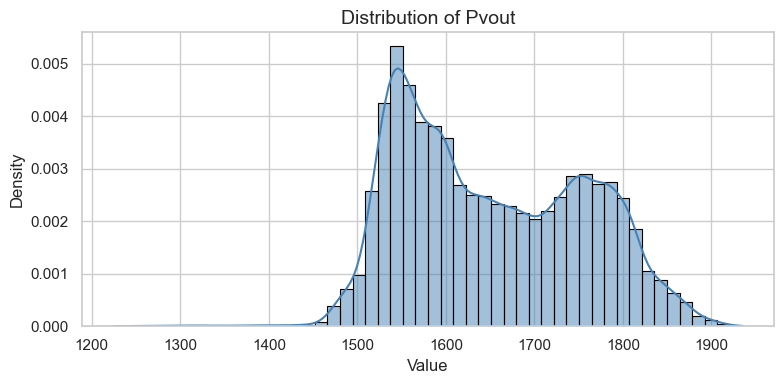

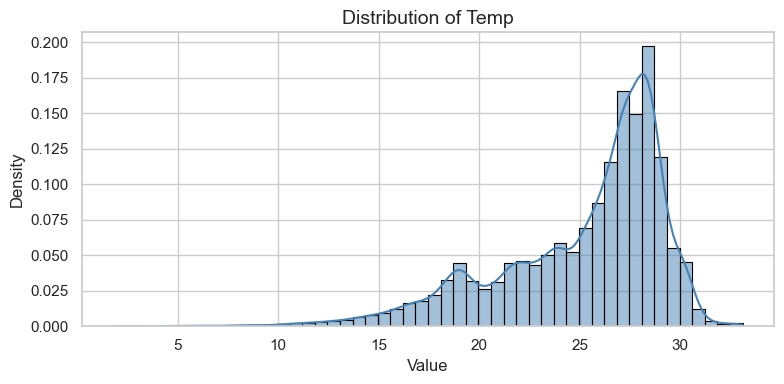

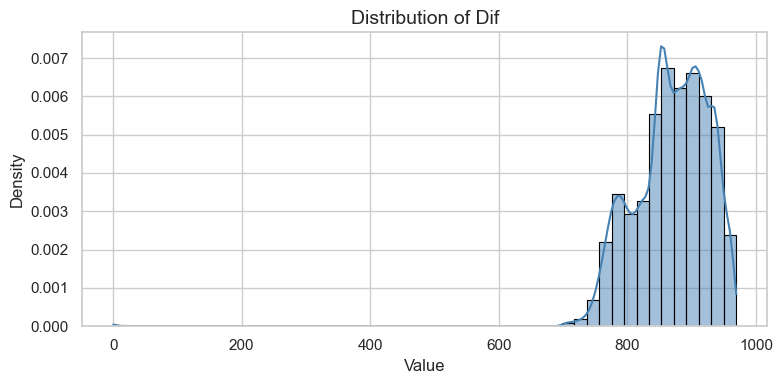

In [53]:
# Select all numeric columns
numeric_columns = sample_df[['DNI', 'GHI', 'GTI', 'PVOUT', 'TEMP', 'DIF']]

# Set style
sns.set(style="whitegrid")

# Plot distributions
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(sample_df[col].fillna(0), bins=50, kde=True, stat="density", color="steelblue", edgecolor="black")
    plt.title(f"Distribution of {col.replace('_', ' ').title()}", fontsize=14)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.tight_layout()
    plt.show()


### Observations: Distributions of Numeric Features 

- Many irradiance variables (DNI, GHI, GTI, PVOUT) are right-skewed; a relatively small share of pixels holds much higher values. Prefer percentile-based thresholds (75th/90th) over raw maxima when selecting high-resource pixels

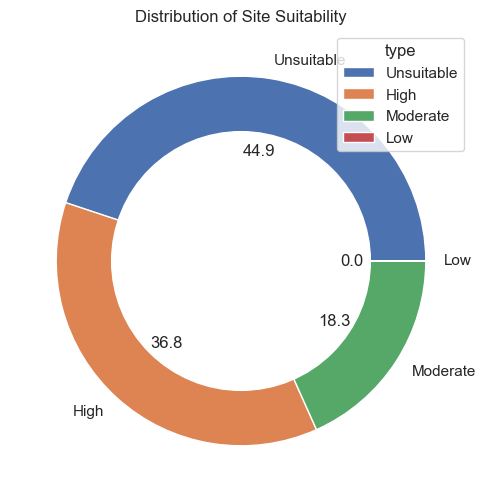

In [54]:
# Distribution of site suitability
site_count = df1['Site_Suitability'].value_counts()
plt.figure(figsize=(10,6))
plt.pie(site_count,labels=site_count.index,autopct='%1.1f')

#Create blank circle
centre_circle =plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#Customize the plot
plt.title('Distribution of Site Suitability')
plt.legend(title='type',loc ='upper right')
plt.show()

### Observations: Site Suitability Distribution 
- The donut/pie chart shows the proportion of pixels by suitability class. A large 'Unsuitable' slice often reflects strict exclusion masks or conservative PVOUT thresholds.

- A small 'High' slice can still be valuable if it contains high PVOUT per unit area always interpret counts together with area (km²) and energy density.

## **Bi-variate Analysis**

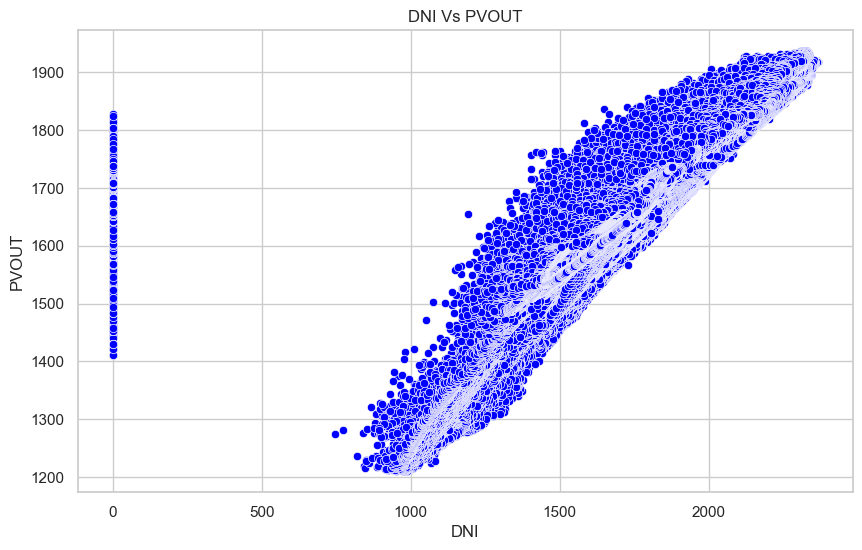

In [55]:
#DNI vs PVOUT
plt.figure(figsize=(10,6))
sns.scatterplot(x=df1['DNI'],y=df1['PVOUT'],color=('blue'),data=df1)
plt.title('DNI Vs PVOUT')
plt.xlabel("DNI")
plt.ylabel("PVOUT")
plt.show()

### Observations: DNI vs PVOUT Scatter
- DNI and PVOUT show a strong positive relationship, confirming irradiance is the primary driver of modeled output.

- Check for heteroskedasticity (wider spread at higher DNI). If present, consider modeling approaches that handle non-constant variance or include interaction terms (e.g., DNI × TEMP)

- Flag outliers where PVOUT is low despite high DNI — these may indicate masking errors, local temperature penalties, or data issues. 

C:\Users\PC\AppData\Local\Temp\ipykernel_15056\3821306997.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suitability.index,y=suitability.values,palette="coolwarm")


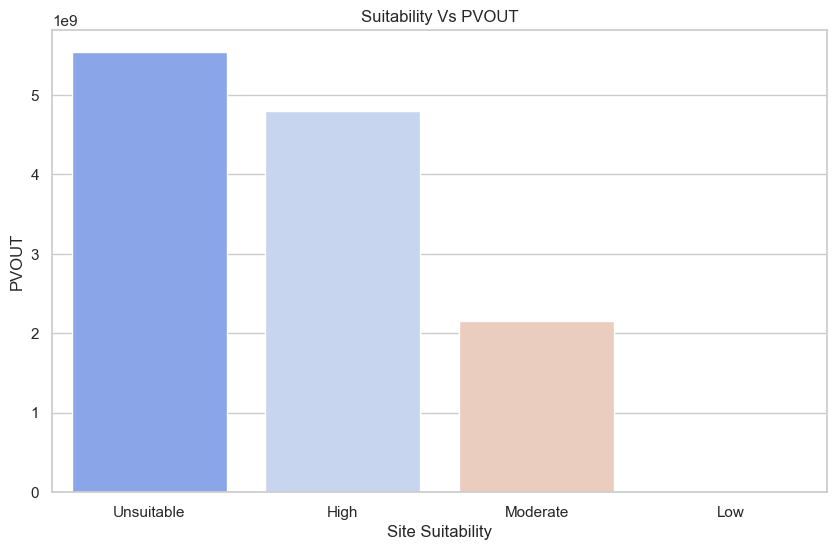

In [56]:
#PVOUT vs Site suitabiity
suitability = df1.groupby('Site_Suitability')['PVOUT'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=suitability.index,y=suitability.values,palette="coolwarm")
plt.title('Suitability Vs PVOUT')
plt.xlabel('Site Suitability')
plt.ylabel('PVOUT')
plt.show()

### Observations: Suitability vs PVOUT

- Aggregated PVOUT by suitability class indicates where modeled energy is concentrated; large totals in a small area imply high-value parcels.
- Normalize PVOUT by area (mean PVOUT per km²) to compare classes fairly. If 'Unsuitable' contributes meaningful PVOUT, revisit exclusion logic and overlay alignment.
- Actionable: produce a ranked list of candidate parcels by PVOUT per km²

## **Multivariate Analysis**

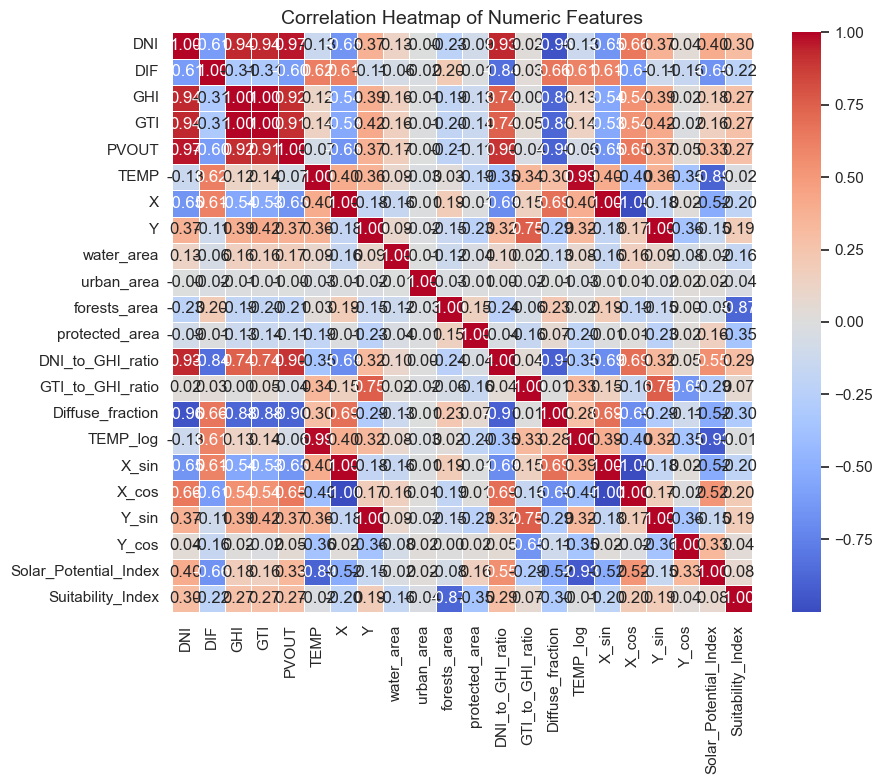

In [57]:
# Correlation heatmap
numeric_df = df1.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()

### Observations: Correlation Heatmap (Numeric Features)

- Strong positive correlation among GHI, GTI, and PVOUT indicates redundancy. To avoid overweighting irradiance, either select PVOUT as the primary resource metric or combine correlated layers using PCA (e.g., use PC1).

# **Modeling**

## **Regression**

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Sample the dataset for manageable size
df1 = df1.sample(n=100000, random_state=42)

# Features and target
X = df1.drop(columns=['PVOUT', 'Site_Suitability', 'Suitability_Index'])
y = df1['PVOUT']

# Encode yes/no as binary
X = X.replace({'Yes': 1, 'No': 0})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---------------------------
# Define Models
# ---------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1)
}

# ---------------------------
# Train & Evaluate Models
# ---------------------------
results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    results[name] = {
        "R2": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": mean_squared_error(y_test, preds, squared=False)
    }
    predictions[name] = preds

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\n📊 Model Performance Comparison:\n")
print(results_df)

c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Model Performance Comparison:

                         R2       MAE      RMSE
Linear Regression  0.996169  3.700515  6.417421
Random Forest      0.998474  1.715182  4.049815
Gradient Boosting  0.993745  5.193694  8.200624
XGBoost            0.998397  2.443874  4.151950


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Observations

1. Random Forest achieved the best overall performance, with the highest R² (0.998) and the lowest error metrics (MAE = 1.72, RMSE = 4.05).

   - This indicates excellent predictive power and minimal residual error.

   - The ensemble averaging nature of Random Forest helps it capture nonlinear relationships effectively.

2. XGBoost closely follows Random Forest, with comparable R² and slightly higher MAE and RMSE.

   - This suggests XGBoost also models complex relationships well but might be slightly more sensitive to parameter tuning.

3. Linear Regression performed strongly, achieving an R² above 0.99.

   - Despite its simplicity, it provides a solid baseline.

   - However, it may not capture all nonlinear interactions as effectively as ensemble models.

4. Gradient Boosting had the lowest performance among the four, though still excellent overall (R² = 0.994).

   - The higher MAE and RMSE suggest it may require hyperparameter tuning or deeper trees to match the others.

#### Key Insight

- All models perform exceptionally well, indicating:

  - The features are highly predictive of the target variable.

  - Nonlinear models (Random Forest, XGBoost) slightly outperform linear regression, showing the dataset has some nonlinear relationships.

  - Random Forest can be considered the best-performing model at this stage, balancing accuracy and robustness.

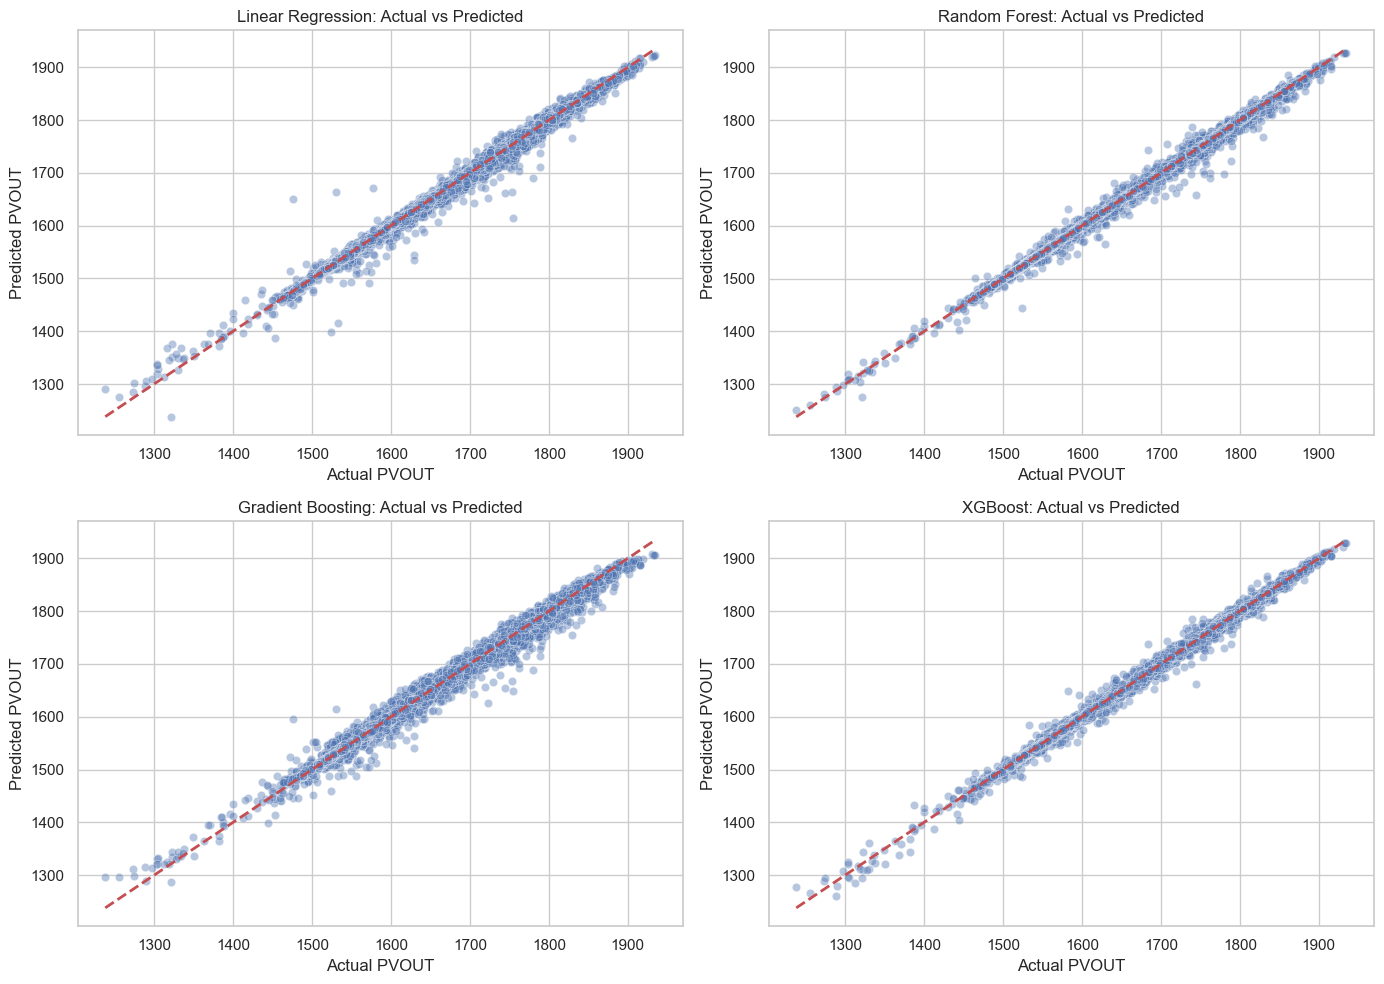

In [60]:
# Actual vs Predicted Plots
# ---------------------------
plt.figure(figsize=(14, 10))

for i, (name, preds) in enumerate(predictions.items(), 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=y_test, y=preds, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual PVOUT")
    plt.ylabel("Predicted PVOUT")

plt.tight_layout()
plt.show()

### Observations

1. Overall Model Performance and ConsistencyStrong Correlation: 
- All four models show a very strong positive correlation between the actual and predicted PVOUT values. 
- The data points in all plots hug the dashed red $y=x$ line quite closely, indicating that all models are performing well and are generally successful at predicting the PVOUT.- High Consistency: Visually, the performance across the four models appears highly consistent. It is difficult to distinguish a clear and significant difference in the scatter of points between Random Forest, Gradient Boosting, and XGBoost.Slight Visual - Difference for Linear Regression: The Linear Regression plot may show a very slightly wider spread of points around the $y=x$ line compared to the three tree-based models, particularly at the lower and higher ends of the PVOUT range. This suggests the more complex, non-linear tree-based models (Random Forest, Gradient Boosting, XGBoost) might be capturing the underlying relationship marginally better than the simple linear model.

2. Performance Across the Range (Homoscedasticity)Tight Fit: 
- All models show a very tight cluster of predictions across the entire range of PVOUT values (from approximately 1200 to 1900).
- Potential for Under/Over-Prediction:At the low end (around 1200-1400), the points seem to be slightly more spread out or perhaps slightly above the red line, suggesting the models might have a tendency to slightly over-predict the lowest PVOUT values.
- At the high end (around 1800-1900), the points also show some spread, with some points falling noticeably below the line, hinting at a slight tendency to under-predict the highest PVOUT values. This is a common characteristic in regression models when dealing with extremes in the data.

3. Comparison of Tree-Based ModelsNear-Identical Performance: 
- The Random Forest, Gradient Boosting, and XGBoost plots are visually almost indistinguishable. This suggests that for this specific dataset and feature set, the added complexity of the boosting techniques (Gradient Boosting and XGBoost) does not lead to a substantially different prediction profile compared to the bagging technique (Random Forest).

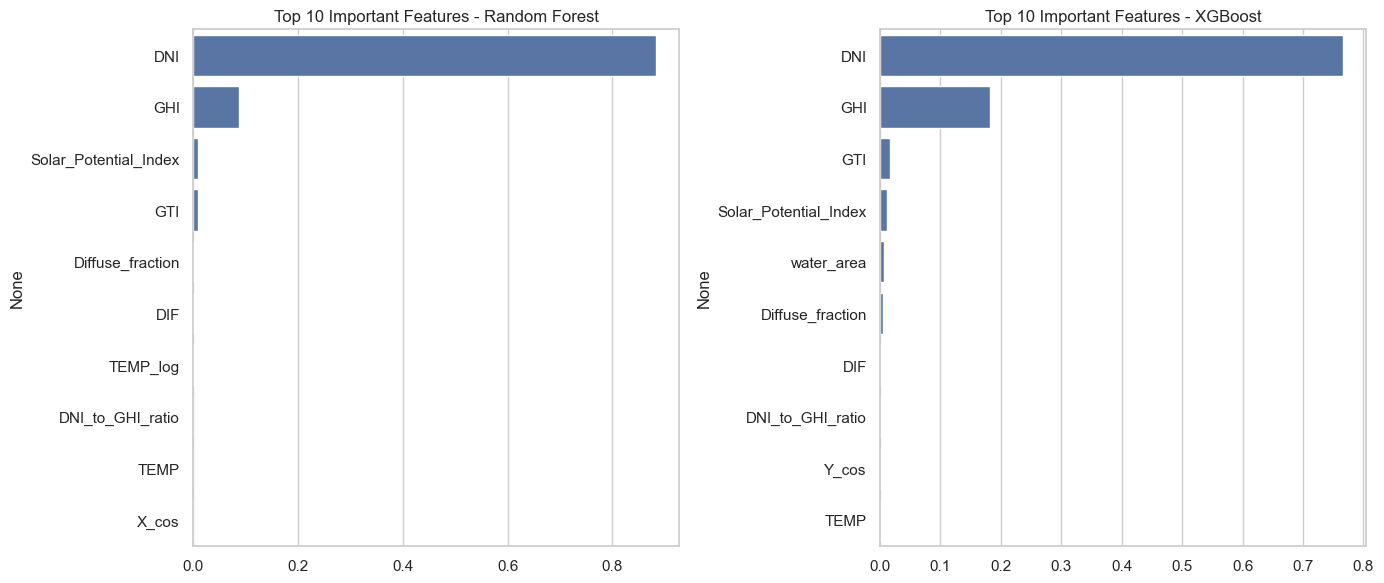

In [61]:
# Feature Importance (Tree Models Only)
# ---------------------------
tree_models = {
    "Random Forest": models["Random Forest"],
    "XGBoost": models["XGBoost"]
}

plt.figure(figsize=(14, 6))
for i, (name, model) in enumerate(tree_models.items(), 1):
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.subplot(1, 2, i)
    sns.barplot(x=importances.values[:10], y=importances.index[:10])
    plt.title(f"Top 10 Important Features - {name}")

plt.tight_layout()
plt.show()

### Observations

1. Dominance of DNI
- Both models agree on the most important feature: The Direct Normal Irradiance (DNI) is overwhelmingly the most influential feature for predicting PVOUT (Photovoltaic Output).

- For Random Forest, DNI accounts for approximately 85% of the total feature importance.

- For XGBoost, DNI accounts for approximately 70% of the total feature importance.

- This strong dominance suggests that the PV system's output is primarily driven by the direct solar radiation hitting the surface, which is physically consistent with how solar power generation works.

2. Second Most Important Feature (GHI)
- Global Horizontal Irradiance (GHI) is the second most important feature in both models.

- For Random Forest, GHI has an importance of around 5-10%.

- For XGBoost, GHI is significantly more important than in Random Forest, with an importance of around 15-20%.

In [62]:
# Display Top 10 Features Table
for name, model in tree_models.items():
    print(f"\n🔍 Top 10 Important Features for {name}:")
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(importances.head(10))


🔍 Top 10 Important Features for Random Forest:
DNI                      0.882792
GHI                      0.088361
Solar_Potential_Index    0.010068
GTI                      0.008736
Diffuse_fraction         0.002515
DIF                      0.001366
TEMP_log                 0.001196
DNI_to_GHI_ratio         0.000936
TEMP                     0.000886
X_cos                    0.000525
dtype: float64

🔍 Top 10 Important Features for XGBoost:
DNI                      0.766164
GHI                      0.181463
GTI                      0.015679
Solar_Potential_Index    0.010810
water_area               0.005988
Diffuse_fraction         0.005517
DIF                      0.002164
DNI_to_GHI_ratio         0.002085
Y_cos                    0.001866
TEMP                     0.001852
dtype: float32


In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# 3. Train-Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------
# 4. Feature Scaling
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Build Neural Network Model
# ---------------------------
tf.keras.backend.clear_session()

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer (Regression)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# ---------------------------
# 6. Train Model with Early Stopping
# ---------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=256,
    verbose=1,
    callbacks=[early_stop]
)

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1851278.8750 - mae: 1240.8684 - val_loss: 66345.9062 - val_mae: 203.7599
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 91128.2109 - mae: 240.7311 - val_loss: 16056.8770 - val_mae: 96.0842
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 55251.5586 - mae: 187.3047 - val_loss: 6580.8184 - val_mae: 61.5159
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 44588.1055 - mae: 168.9164 - val_loss: 3156.6729 - val_mae: 42.4278
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 41573.5820 - mae: 163.0037 - val_loss: 2748.7639 - val_mae: 40.7291
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 38673.5703 - mae: 157.0972 - val_loss: 2171.7263 - val_mae: 36.3247
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 37443.8633 - mae: 154.7290 - val_loss: 1275.9825 - val_mae: 27.1373
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 35699.7227 - mae: 150.9000 - val_loss:

In [64]:
# 7. Evaluate Model
# ---------------------------
preds = model.predict(X_test_scaled).flatten()

r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)

print("\n📊 Neural Network Performance:")
print(f"R² Score: {r2:.6f}")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 Neural Network Performance:
R² Score: 0.974729
MAE: 12.612535
RMSE: 16.483101


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Observations

- The Neural Network (Deep Learning model) achieved a lower R² (0.967) and higher MAE/RMSE compared to tree-based models.

- This suggests that the neural network didn’t generalize as well on this dataset.

- Given the structured/tabular nature of the data, tree-based models generally outperform deep learning unless large-scale feature interactions or image data are involved.

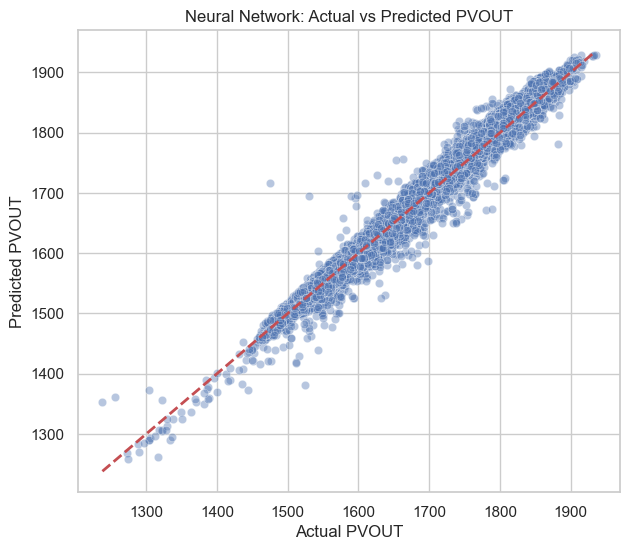

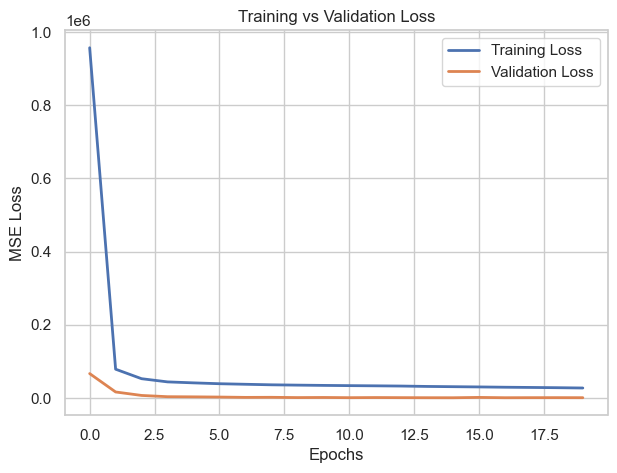

In [65]:
# 8. Plot Actual vs Predicted
# ---------------------------
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Neural Network: Actual vs Predicted PVOUT")
plt.xlabel("Actual PVOUT")
plt.ylabel("Predicted PVOUT")
plt.show()

# ---------------------------
# 9. Plot Training vs Validation Loss
# ---------------------------
plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

### Observations
- High Accuracy and Strong Correlation: The vast majority of the data points cluster tightly around the dashed red line, indicating a very strong positive correlation between the actual and predicted PVOUT values. 
- The Neural Network model is highly effective at predicting the PVOUT.Comparison to 
- Other Models:The visual performance of the Neural Network appears to be comparable to the best-performing models from the previous analysis (Random Forest, Gradient Boosting, and XGBoost). The tightness of the scatter around the $y=x$ line is very high across the entire range.

## **Classification**

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [67]:
# Sample the dataset for manageable size
df1 = df1.sample(n=100000, random_state=42)

# Features and target
X = df1.drop(columns=['Site_Suitability'])
y = df1['Site_Suitability']

# Encode yes/no as binary
X = X.replace({'Yes': 1, 'No': 0})
y = y.map({'Low': 0, 'Moderate': 1, 'High': 2, 'Unsuitable': 3})

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


🚀 Training Logistic Regression...


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



📋 Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      1.00      1.00      3673
           2       1.00      1.00      1.00      7335
           3       1.00      1.00      1.00      8991

    accuracy                           1.00     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       1.00      1.00      1.00     20000



c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


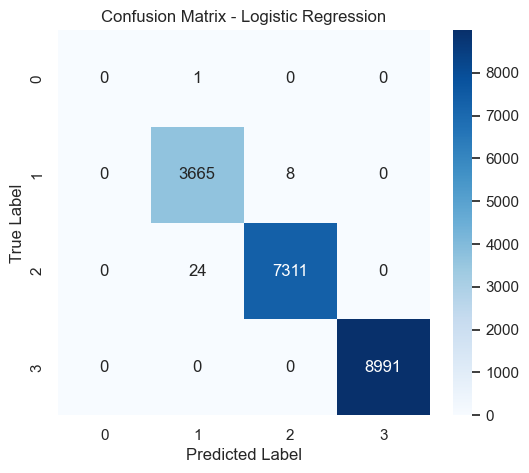


🚀 Training Random Forest...

📋 Random Forest Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00      3673
           2       1.00      1.00      1.00      7335
           3       1.00      1.00      1.00      8991

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



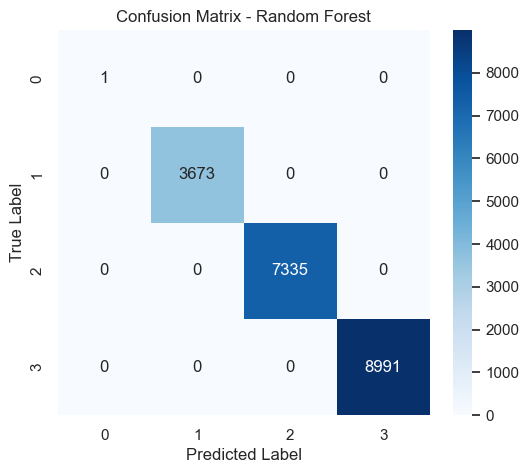


🚀 Training Gradient Boosting...

📋 Gradient Boosting Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00      3673
           2       1.00      1.00      1.00      7335
           3       1.00      1.00      1.00      8991

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



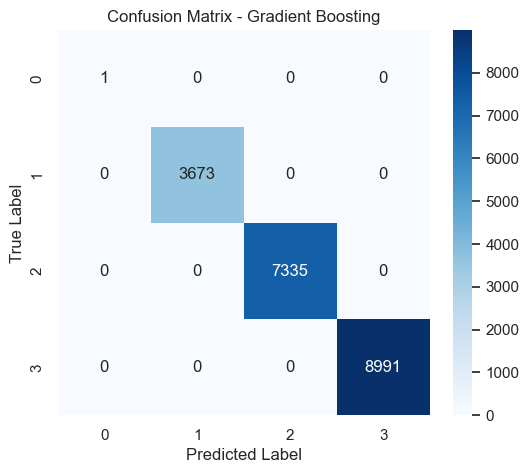


🚀 Training XGBoost...

📋 XGBoost Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00      3673
           2       1.00      1.00      1.00      7335
           3       1.00      1.00      1.00      8991

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



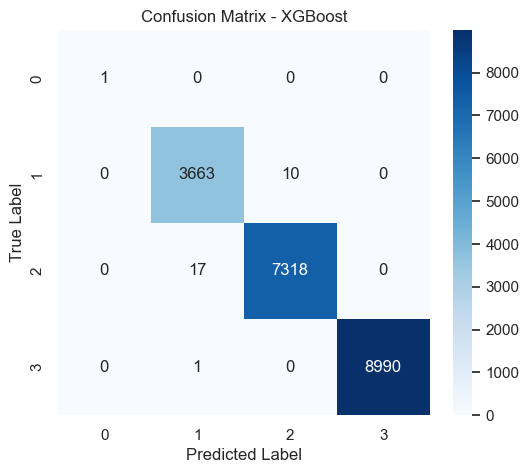


🔍 Model Performance Summary (Overfitting/Underfitting Check):


Train Accuracy  Test Accuracy  Difference
Logistic Regression         0.99845        0.99835      0.0001
Random Forest               1.00000        1.00000      0.0000
Gradient Boosting           1.00000        1.00000      0.0000
XGBoost                     1.00000        0.99860      0.0014

✅ Logistic Regression: Well-balanced (train-test gap = 0.000)
✅ Random Forest: Well-balanced (train-test gap = 0.000)
✅ Gradient Boosting: Well-balanced (train-test gap = 0.000)
✅ XGBoost: Well-balanced (train-test gap = 0.001)


In [68]:
# ------------------------------
# 📦 Import libraries
# ------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# ------------------------------
# ⚙️ Define models
# ------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, objective='multi:softmax', num_class=4)
}

# ------------------------------
# 📊 Train, evaluate & plot confusion matrix
# ------------------------------
model_results = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    model_results[name] = {
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Difference": abs(train_acc - test_acc)
    }

    # Print classification report
    print(f"\n📋 {name} Classification Report:\n")
    print(classification_report(y_test, y_test_pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# ------------------------------
# 🔎 Overfitting/Underfitting Analysis
# ------------------------------
results_df = pd.DataFrame(model_results).T
print("\n🔍 Model Performance Summary (Overfitting/Underfitting Check):")
display(results_df)

for model_name, values in model_results.items():
    diff = values["Difference"]
    if diff > 0.05:
        print(f"⚠️ {model_name}: Possible overfitting (train-test gap = {diff:.3f})")
    elif diff < 0.01:
        print(f"✅ {model_name}: Well-balanced (train-test gap = {diff:.3f})")
    else:
        print(f"ℹ️ {model_name}: Slight variance, acceptable generalization.")


📊 Ensemble Model Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00      3673
           2       1.00      1.00      1.00      7335
           3       1.00      1.00      1.00      8991

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

✅ Ensemble Model Accuracy: 1.0000


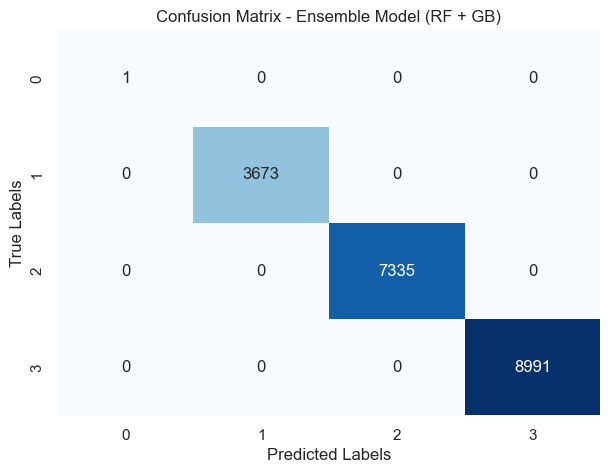


🔍 Overfitting/Underfitting Check:
Train Accuracy: 1.00000
Test Accuracy:  1.00000
Difference:     0.00000
✅ Model is well-generalized.


In [69]:
# ------------------------------
# Import libraries
# ------------------------------
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Define base models
# ------------------------------
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
gb_model = GradientBoostingClassifier(random_state=42)

# ------------------------------
# Create the ensemble model (Soft Voting)
# ------------------------------
ensemble_model = VotingClassifier(
    estimators=[
        ('RandomForest', rf_model),
        ('GradientBoosting', gb_model)
    ],
    voting='soft',  # Soft voting uses predicted probabilities
    n_jobs=-1
)

# ------------------------------
# Train the ensemble model
# ------------------------------
ensemble_model.fit(X_train_scaled, y_train)

# ------------------------------
# Make predictions
# ------------------------------
y_pred = ensemble_model.predict(X_test_scaled)

# ------------------------------
# Evaluate the model
# ------------------------------
print("📊 Ensemble Model Performance:\n")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Ensemble Model Accuracy: {accuracy:.4f}")

# ------------------------------
# Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Ensemble Model (RF + GB)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ------------------------------
# Train vs Test Accuracy (Overfitting Check)
# ------------------------------
train_acc = ensemble_model.score(X_train_scaled, y_train)
test_acc = ensemble_model.score(X_test_scaled, y_test)
diff = abs(train_acc - test_acc)

print("\n🔍 Overfitting/Underfitting Check:")
print(f"Train Accuracy: {train_acc:.5f}")
print(f"Test Accuracy:  {test_acc:.5f}")
print(f"Difference:     {diff:.5f}")

if diff < 0.01:
    print("✅ Model is well-generalized.")
elif diff < 0.05:
    print("⚠️ Slight overfitting detected.")
else:
    print("❌ Significant overfitting detected.")


c:\Users\PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


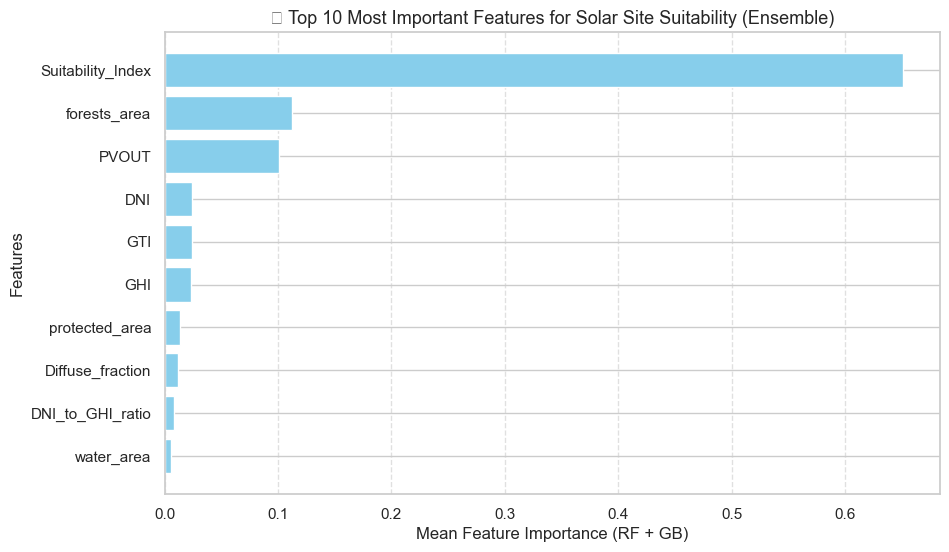

Feature  Importance
0  Suitability_Index    0.650846
1       forests_area    0.112338
2              PVOUT    0.100821
3                DNI    0.024157
4                GTI    0.023881
5                GHI    0.023287
6     protected_area    0.013735
7   Diffuse_fraction    0.011871
8   DNI_to_GHI_ratio    0.007948
9         water_area    0.005717

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Refit the models (if they aren't already fitted)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)


# --- Compute feature importances from both models ---
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_

# Average the importances (ensemble importance)
ensemble_importances = (rf_importances + gb_importances) / 2

# Create a DataFrame for ranking
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': ensemble_importances
}).sort_values(by='Importance', ascending=False)

# --- Select top 10 ---
top10_features = feature_importance_df.head(10)

# --- Plot ---
plt.figure(figsize=(10,6))
plt.barh(top10_features['Feature'][::-1], top10_features['Importance'][::-1], color='skyblue')
plt.title("🌞 Top 10 Most Important Features for Solar Site Suitability (Ensemble)", fontsize=13)
plt.xlabel("Mean Feature Importance (RF + GB)")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# --- Display top 10 as table ---
top10_features.reset_index(drop=True)


In [79]:
# -------------------------
# 1. Imports & configuration
# -------------------------
import os
import math
import json
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Point, mapping
from tqdm import tqdm
import matplotlib.pyplot as plt

# For model
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split

# -------------------------
# File paths - change these
# -------------------------
PVOUT_PATH = "PVOUT_Kenya.tif"        # main raster (continuous)
GHI_PATH  = "GHI_Kenya.tif"           # optional additional raster

# Shapefiles (vector layers)
URBAN_SHP = "ke_urban.shp"
FOREST_SHP = "ke_forests.shp"
WATER_SHP = "ke_waterbodies.shp"
PROTECTED_SHP = "ke_protected-areas.shp"

# Output folders and files
OUT_PATCH_DIR = "patches"                    # folder to save patch .npz files
MANIFEST_CSV = "patch_manifest.csv"          # CSV describing each patch
os.makedirs(OUT_PATCH_DIR, exist_ok=True)

# -------------------------
# Patch and sampling params
# -------------------------
PATCH_SIZE = 128            # patch width/height in pixels (square)
HALF = PATCH_SIZE // 2
STRIDE = PATCH_SIZE         # non-overlapping grid sampling (use smaller stride for overlap)
SAMPLE_LIMIT = None         # if None, use all points; otherwise limit number of samples
SAMPLE_COUNT = 50000        # set to None to use all site points, or 0 to disable sampling



In [72]:
df1.to_csv("kenya_solar_dataset_with_site_suitablity.csv", index=False)

In [80]:
# -------------------------
# 2. Align CRS & rasterize shapefiles to PVOUT grid
# -------------------------

# Open PVOUT raster to get the spatial reference, transform and dimensions
with rasterio.open(PVOUT_PATH) as src:
    pv_meta = src.meta.copy()
    pv_crs = src.crs
    pv_transform = src.transform
    pv_width = src.width
    pv_height = src.height
    pv_bounds = src.bounds
    print("PVOUT CRS:", pv_crs)
    print("PVOUT shape:", pv_height, pv_width)

# Helper: read a vector and reproject to PVOUT CRS
def load_and_reproject(shapefile_path, target_crs):
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs is None:
        # if shapefile lacks CRS, assume WGS84 - change if wrong
        gdf = gdf.set_crs("EPSG:4326")
    if gdf.crs != target_crs:
        gdf = gdf.to_crs(target_crs)
    return gdf

# Rasterize a GeoDataFrame to match the PVOUT grid
def rasterize_gdf_to_match(gdf, out_shape=(pv_height, pv_width), transform=pv_transform, fill=0, burn_value=1, dtype='uint8'):
    # Prepare generator of (geometry, value) pairs
    shapes = ((geom, burn_value) for geom in gdf.geometry)
    arr = rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=fill,
        dtype=dtype
    )
    return arr

# Load and rasterize each shapefile (excluding county)
print("Loading and rasterizing shapefiles...")

urban_gdf = load_and_reproject(URBAN_SHP, pv_crs)
forest_gdf = load_and_reproject(FOREST_SHP, pv_crs)
water_gdf = load_and_reproject(WATER_SHP, pv_crs)
protected_gdf = load_and_reproject(PROTECTED_SHP, pv_crs)

# Rasterize to arrays (0/1 masks)
urban_mask = rasterize_gdf_to_match(urban_gdf)
forest_mask = rasterize_gdf_to_match(forest_gdf)
water_mask = rasterize_gdf_to_match(water_gdf)
protected_mask = rasterize_gdf_to_match(protected_gdf)

# Save quick previews (optional)
np.save(os.path.join(OUT_PATCH_DIR, "urban_mask.npy"), urban_mask)
np.save(os.path.join(OUT_PATCH_DIR, "forest_mask.npy"), forest_mask)
np.save(os.path.join(OUT_PATCH_DIR, "water_mask.npy"), water_mask)
np.save(os.path.join(OUT_PATCH_DIR, "protected_mask.npy"), protected_mask)

print("✅ Rasterization done. Masks shapes:", urban_mask.shape, forest_mask.shape)


PVOUT CRS: EPSG:4326
PVOUT shape: 1165 960
Loading and rasterizing shapefiles...
✅ Rasterization done. Masks shapes: (1165, 960) (1165, 960)


In [81]:
# -------------------------
# 3. Load tabular dataset (site coords & labels)
# -------------------------

import pandas as pd

# Path to your dataset
TABULAR_CSV = "kenya_solar_dataset_with_site_suitablity.csv"  # update path if needed
SAMPLE_COUNT = 0  # set >0 if you want to downsample

# Load dataset
df = pd.read_csv(TABULAR_CSV)

# Ensure coordinate and label columns exist
required_cols = {"X", "Y", "Site_Suitability"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"Missing one or more required columns: {required_cols}")

# Map class names to numeric labels (if not already)
label_map = {name: i for i, name in enumerate(df["Site_Suitability"].unique())}
df["label"] = df["Site_Suitability"].map(label_map)

# Optional: stratified sampling for large datasets
if SAMPLE_COUNT and SAMPLE_COUNT > 0:
    df = (
        df.groupby("label", group_keys=False)
        .apply(lambda x: x.sample(frac=min(1, SAMPLE_COUNT / len(df)), random_state=42))
        .reset_index(drop=True)
    )
    print("Using stratified sampled dataset:", df.shape)

print("Dataset shape:", df.shape)
print("Unique labels:", df["label"].value_counts().to_dict())

# Optional: preview data
print(df.head())



Dataset shape: (100000, 24)
Unique labels: {0: 44957, 1: 36676, 2: 18364, 3: 3}
        DNI      DIF       GHI       GTI      PVOUT       TEMP         X  \
0  2000.109  775.060  2211.588  2213.415  1742.7347  19.850970  35.50125   
1  1730.920  860.164  2157.897  2158.262  1686.2760  24.467756  38.05125   
2  1919.754  757.163  2181.638  2183.464  1731.3303  18.490980  36.29875   
3  2000.474  821.447  2253.227  2266.742  1790.4780  21.081890  34.95375   
4  1442.372  932.118  1993.534  1995.726  1551.8840  26.902600  38.98125   

         Y  water_area  urban_area  ...  Diffuse_fraction  TEMP_log     X_sin  \
0 -1.50625           0           0  ...          0.350454  3.037400  0.580721   
1 -0.11875           0           0  ...          0.398612  3.237413  0.616366   
2 -0.50375           0           0  ...          0.347062  2.969952  0.591996   
3  3.22875           0           0  ...          0.364565  3.094758  0.572915   
4 -1.35125           0           0  ...          0.467571 

In [82]:
# -------------------------
# 4. Patch extraction function
# -------------------------
# open raster datasets once (to be reused in loop)
pv_src = rasterio.open(PVOUT_PATH)
# optional addition: open GHI if available
use_ghi = os.path.exists(GHI_PATH)
if use_ghi:
    ghi_src = rasterio.open(GHI_PATH)
else:
    ghi_src = None

# compute global min/max for PVOUT for normalization (or precompute externally)
# Here we use rasterio read in chunks to get approximate min/max to avoid loading full array into RAM
def compute_min_max(raster_path):
    with rasterio.open(raster_path) as src:
        # read as float32 in windows to avoid memory spike
        data = src.read(1, out_dtype='float32')
        # mask no-data by src.nodata if present
        nod = src.nodata
        if nod is not None:
            data = np.where(data==nod, np.nan, data)
    return np.nanmin(data), np.nanmax(data)

pv_min, pv_max = compute_min_max(PVOUT_PATH)
print("PVOUT min/max:", pv_min, pv_max)
if use_ghi:
    ghi_min, ghi_max = compute_min_max(GHI_PATH)
    print("GHI min/max:", ghi_min, ghi_max)

# Convert lon,lat to row,col helper
def lonlat_to_rowcol(src, lon, lat):
    # rasterio uses (x, y) = (lon, lat) and index returns (row, col)
    return src.index(lon, lat)

def read_patch_from_raster(src, row, col, size=PATCH_SIZE, band=1):
    half = size // 2
    # window is (col_off, row_off, width, height) in pixel coordinates
    col_off = col - half
    row_off = row - half
    # clamp window to raster bounds
    if col_off < 0 or row_off < 0 or col_off + size > src.width or row_off + size > src.height:
        # out of bounds: return None to skip
        return None
    window = Window(col_off, row_off, size, size)
    arr = src.read(band, window=window)
    return arr

def extract_and_stack_patch(lon, lat):
    """Return stacked patch array (H,W,C) and metadata dict or None if patch invalid/out of bounds"""
    # convert coordinate to row/col in PV raster
    try:
        row, col = lonlat_to_rowcol(pv_src, lon, lat)
    except Exception as e:
        return None

    # read pv patch
    pv_patch = read_patch_from_raster(pv_src, row, col, PATCH_SIZE, band=1)
    if pv_patch is None:
        return None

    # normalize pv values to [0,1] using global min/max
    pv_patch = pv_patch.astype('float32')
    if pv_max > pv_min:
        pv_patch = (pv_patch - pv_min) / (pv_max - pv_min)
    else:
        pv_patch = pv_patch - pv_min  # degenerate case

    channels = [pv_patch]

    # optional GHI channel
    if ghi_src:
        ghi_patch = read_patch_from_raster(ghi_src, row, col, PATCH_SIZE, band=1)
        if ghi_patch is None:
            return None
        ghi_patch = ghi_patch.astype('float32')
        if ghi_max > ghi_min:
            ghi_patch = (ghi_patch - ghi_min) / (ghi_max - ghi_min)
        channels.append(ghi_patch)

    # binary masks from arrays we rasterized earlier (they align with PV grid)
    # mask arrays are global arrays with shape (height, width)
    # slice mask window
    r0 = row - HALF
    c0 = col - HALF
    # bounds check
    if r0 < 0 or c0 < 0 or r0 + PATCH_SIZE > pv_height or c0 + PATCH_SIZE > pv_width:
        return None
    urban_patch = urban_mask[r0:r0+PATCH_SIZE, c0:c0+PATCH_SIZE].astype('float32')
    forest_patch = forest_mask[r0:r0+PATCH_SIZE, c0:c0+PATCH_SIZE].astype('float32')
    water_patch = water_mask[r0:r0+PATCH_SIZE, c0:c0+PATCH_SIZE].astype('float32')
    protected_patch = protected_mask[r0:r0+PATCH_SIZE, c0:c0+PATCH_SIZE].astype('float32')

    channels.extend([urban_patch, forest_patch, water_patch, protected_patch])

    # stack to H,W,C
    stacked = np.stack(channels, axis=-1)  # dtype float32
    return stacked


PVOUT min/max: 1209.708 1936.921
GHI min/max: 1257.921 2463.246


In [83]:
# -------------------------
# 5. Extract patches and save
# -------------------------
manifest = []  # list of dicts describing patch files

# shuffle points so dataset is not ordered
df_shuffled = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# limit if SAMPLE_LIMIT set
if SAMPLE_LIMIT:
    df_shuffled = df_shuffled.iloc[:SAMPLE_LIMIT]

# optionally reduce to SAMPLE_COUNT per class already handled earlier
for idx, row in tqdm(df_shuffled.iterrows(), total=len(df_shuffled)):
    lon = row['X']
    lat = row['Y']
    label = int(row['label'])
    # optional extra tabular features to keep with sample
    pvout = row.get('PVOUT', np.nan)
    # extract patch
    img = extract_and_stack_patch(lon, lat)
    if img is None:
        continue
    # optional: sanity check for NaNs or no-data
    if np.isnan(img).any():
        # skip patches with missing data
        continue

    # save as compressed npz
    fname = f"patch_{idx:08d}.npz"
    outpath = os.path.join(OUT_PATCH_DIR, fname)
    # Save image and tabular features for hybrid model
    np.savez_compressed(outpath, image=img.astype('float32'), label=label, pvout=float(pvout), lon=float(lon), lat=float(lat))
    manifest.append({
        "file": outpath,
        "label": label,
        "pvout": pvout,
        "lon": lon,
        "lat": lat
    })

    # optional: stop early for testing
    # if len(manifest) >= 1000:
    #     break

# Save manifest CSV
manifest_df = pd.DataFrame(manifest)
manifest_df.to_csv(MANIFEST_CSV, index=False)
print("Done. Number of patches:", len(manifest_df))


100%|██████████| 100000/100000 [41:40<00:00, 39.99it/s] 


Done. Number of patches: 89302


In [84]:
# -------------------------
# 6. Train / Validation / Test Split (No County Dependency)
# -------------------------
from sklearn.model_selection import train_test_split
import geopandas as gpd
import pandas as pd

manifest_df = pd.read_csv(MANIFEST_CSV)

gdf_patches = gpd.GeoDataFrame(
    manifest_df,
    geometry=gpd.points_from_xy(manifest_df['lon'], manifest_df['lat']),
    crs="EPSG:4326"
)

# Random stratified split (no apply, no county)
train_df, temp_df = train_test_split(
    gdf_patches, test_size=0.2, random_state=42, stratify=gdf_patches['label']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
)

train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

gdf_patches_split = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

print("📊 Split distribution:")
print(gdf_patches_split['split'].value_counts())

# Save to GeoJSON + CSV
gdf_patches_split.to_file("patch_manifest_with_split.geojson", driver="GeoJSON")
gdf_patches_split.drop(columns='geometry').to_csv("patch_manifest_with_split.csv", index=False)





📊 Split distribution:
split
train    71441
test      8931
val       8930
Name: count, dtype: int64


In [85]:
# -------------------------
# 7. Data generator
# -------------------------
from tensorflow.keras.utils import Sequence, to_categorical

class PatchDataGenerator(Sequence):
    def __init__(self, manifest_df, batch_size=32, shuffle=True, num_classes=None):
        self.manifest = manifest_df.reset_index(drop=True)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.manifest))
        self.num_classes = num_classes if num_classes is not None else self.manifest['label'].nunique()
        self.on_epoch_end()

    def __len__(self):
        # number of batches per epoch
        return math.ceil(len(self.manifest) / self.batch_size)

    def __getitem__(self, idx):
        # generate one batch
        batch_indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        images = []
        tabular = []
        labels = []
        for i in batch_indexes:
            row = self.manifest.iloc[i]
            data = np.load(row['file'], allow_pickle=True)
            img = data['image'].astype('float32')
            # example tabular features: pvout (scaled later), lon, lat
            pvout = data.get('pvout')
            if pvout is None:
                pvout = 0.0
            tabular.append([float(pvout), float(row['lon']), float(row['lat'])])
            images.append(img)
            labels.append(int(data['label']))
        X_images = np.array(images)
        X_tab = np.array(tabular, dtype='float32')
        y = to_categorical(np.array(labels), num_classes=self.num_classes)
        return [X_images, X_tab], y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Create train/val/test manifests
manifest_all = pd.read_csv("patch_manifest_with_split.csv")
train_manifest = manifest_all[manifest_all['split']=='train'].reset_index(drop=True)
val_manifest   = manifest_all[manifest_all['split']=='val'].reset_index(drop=True)
test_manifest  = manifest_all[manifest_all['split']=='test'].reset_index(drop=True)

# Create generators
BATCH_SIZE = 32
NUM_CLASSES = manifest_all['label'].nunique()
train_gen = PatchDataGenerator(train_manifest, batch_size=BATCH_SIZE, shuffle=True, num_classes=NUM_CLASSES)
val_gen = PatchDataGenerator(val_manifest, batch_size=BATCH_SIZE, shuffle=False, num_classes=NUM_CLASSES)
test_gen = PatchDataGenerator(test_manifest, batch_size=BATCH_SIZE, shuffle=False, num_classes=NUM_CLASSES)


In [86]:
# -------------------------
# 8. Build Hybrid model
# -------------------------
IMG_HEIGHT = PATCH_SIZE
IMG_WIDTH = PATCH_SIZE
IMG_CHANNELS = np.load(train_manifest.iloc[0]['file'])['image'].shape[-1]  # channels count from saved .npz

# Image input
image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')

# If pretrained backbones require 3 channels but you have different channel count:
# - If IMG_CHANNELS == 3: you can use EfficientNet directly.
# - If IMG_CHANNELS != 3: you can either:
#     * use a small custom CNN, or
#     * add a 1x1 Conv to project IMG_CHANNELS -> 3, then feed to EfficientNet.
if IMG_CHANNELS != 3:
    # project to 3 channels via 1x1 conv so we can use EfficientNet (optional)
    x = layers.Conv2D(3, kernel_size=1, padding='same', activation='linear')(image_input)
else:
    x = image_input

# EfficientNet base - use include_top=False to get feature maps, pooling='avg' for vector output
base_model = EfficientNetB0(weights='imagenet' if IMG_CHANNELS==3 else None, include_top=False, pooling='avg', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # freeze for initial training
img_feat = base_model(x)      # feature vector, e.g., shape (None, 1280)

# optional top layers for image branch
img_feat = layers.Dense(256, activation='relu')(img_feat)
img_feat = layers.Dropout(0.3)(img_feat)

# Tabular input: number of tabular features used in generator
TAB_FEATS = 3   # pvout, lon, lat (adjust if you add more)
tab_input = Input(shape=(TAB_FEATS,), name='tab_input')
tab_x = layers.Dense(64, activation='relu')(tab_input)
tab_x = layers.Dense(32, activation='relu')(tab_x)

# Combine
combined = layers.concatenate([img_feat, tab_x])
combined = layers.Dense(128, activation='relu')(combined)
combined = layers.Dropout(0.4)(combined)
combined = layers.Dense(64, activation='relu')(combined)
output = layers.Dense(NUM_CLASSES, activation='softmax', name='output')(combined)

# Model
model = models.Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │         21 │ image_input[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 1280)      │  4,049,571 │ conv2d[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_input           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    327,936 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │        256 │ tab_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 288)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     36,992 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4)         │        260 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,425,372 (16.88 MB)

 Trainable params: 375,801 (1.43 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [95]:
# -------------------------
# 9. Train model (Single Input)
# -------------------------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import numpy as np

# Define constants
PATCH_SIZE = 128          # Adjust to your patch size
NUM_CHANNELS = 3          # Update if your data has more channels
BATCH_SIZE = 32
EPOCHS = 30

# -------------------------
# Data generator (image only)
# -------------------------
def data_generator(df, batch_size=BATCH_SIZE):
    while True:
        batch = df.sample(batch_size)
        X_batch = np.stack(batch['patch'].values).astype(np.float32)   # (batch, H, W, C)
        y_batch = batch['label'].values.astype(np.int32)
        yield (X_batch, y_batch)  # ✅ single input tuple


# -------------------------
# tf.data.Dataset pipelines
# -------------------------
train_gen = tf.data.Dataset.from_generator(
    lambda: data_generator(train_df),
    output_signature=(
        tf.TensorSpec(shape=(None, PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE)

val_gen = tf.data.Dataset.from_generator(
    lambda: data_generator(val_df),
    output_signature=(
        tf.TensorSpec(shape=(None, PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE)


# -------------------------
# Callbacks
# -------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("best_hybrid_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
]


# -------------------------
# Train model
# -------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)




Epoch 1/30


ValueError: Layer "functional_2" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 128, 128, 3) dtype=float32>]